In [143]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import time
import random
import itertools
import  matplotlib.pyplot as plt
import shapely
from shapely.geometry import LineString, Point
from statistics import mean

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import NearestNeighbors
from sklearn.utils import shuffle
from sklearn.metrics import precision_score, \
    recall_score, confusion_matrix, classification_report, \
    accuracy_score, f1_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import OneClassSVM
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.svm import SVR

from behalearn.preprocessing import columns
from behalearn.authentication import authentication_metrics
from behalearn.authentication import authentication_results
from behalearn.estimators import VotingClassifier
from behalearn.features import FeatureExtractor
from behalearn.features import temporal
from behalearn.metrics import fmr_score
from behalearn.metrics import fnmr_score
from behalearn.metrics import eer_score
from behalearn.metrics import hter_score
from behalearn.preprocessing import StartEndSegmentSplitter
from behalearn.preprocessing import SegmentSplitter
from behalearn.preprocessing.segment import criteria
from behalearn.visualization import initialize_notebook_output
from behalearn.visualization import label_touches
from behalearn.visualization import plot_fmr_fnmr
from behalearn.visualization import visualize_mobile_data
from behalearn.visualization import visualize_mouse_data
from behalearn.visualization import visualize_custom_data


In [156]:
segment_column = 'segment'
user_column = 'user'
user_name_column = 'username'
compute_features_for_segment = True
delete_nan_features = False
use_selected_features = False

path_to_raw_data = '../login_datasets/2019-01-08_FIIT_-2-poschodie_po_skuske_KPAIS_correct_patterns_only/'
path_to_featutes = "../login_features/" + ("segments" if compute_features_for_segment else "paterns") + ("" if delete_nan_features else "_nan") + "/"

columns_to_identificate_features = ['id', 'pattern_id','device','scenario', user_name_column, user_column]
if compute_features_for_segment:
    columns_to_identificate_features.append(segment_column)
    
train_y_columns = user_name_column
selected_features_dict={'40_RandomForestClassifierWithCoef(min_samples_leaf=5, n_estimators=500, n_jobs=-1)': ['duration', 'velocity_x_y_mean', 'velocity_x_y_max', 'velocity_x_y_abs_max', 'accelerometer_jerk_x_std', 'accelerometer_jerk_x_z_mean', 'accelerometer_jerk_x_z_upper_q', 'accelerometer_jerk_x_y_z_mean', 'accelerometer_x_mean', 'accelerometer_x_lower_q', 'accelerometer_x_median', 'accelerometer_y_mean', 'accelerometer_y_lower_q', 'accelerometer_y_median', 'accelerometer_y_upper_q', 'accelerometer_z_mean', 'accelerometer_z_lower_q', 'accelerometer_x_y_mean', 'accelerometer_x_z_mean', 'accelerometer_y_z_mean', 'accelerometer_x_y_z_mean', 'gyro_jerk_z_std', 'gyro_jerk_x_y_lower_q', 'gyro_jerk_x_z_mean', 'gyro_jerk_x_z_lower_q', 'gyro_jerk_y_z_median', 'gyro_jerk_y_z_lower_q', 'gyro_jerk_x_y_z_mean', 'gyro_jerk_x_y_z_lower_q', 'gyro_z_std', 'gyro_z_min', 'gyro_z_max', 'gyro_x_y_mean', 'gyro_x_z_mean', 'gyro_x_z_upper_q', 'gyro_x_z_max', 'gyro_y_z_mean', 'gyro_y_z_upper_q', 'gyro_y_z_max', 'gyro_x_y_z_mean'], '100_LogisticRegression()': ['duration', 'length', 'velocity_x_std', 'velocity_x_min', 'velocity_x_max', 'velocity_x_abs_max', 'velocity_x_median', 'velocity_y_std', 'velocity_y_min', 'velocity_y_max', 'velocity_y_abs_min', 'velocity_y_median', 'velocity_y_upper_q', 'velocity_x_y_std', 'velocity_x_y_min', 'velocity_x_y_max', 'velocity_x_y_median', 'velocity_x_y_lower_q', 'velocity_x_y_upper_q', 'acceleration_x_std', 'accelerometer_jerk_x_std', 'accelerometer_jerk_z_std', 'accelerometer_jerk_z_min', 'accelerometer_jerk_x_y_mean', 'accelerometer_jerk_x_y_max', 'accelerometer_jerk_x_y_upper_q', 'accelerometer_jerk_x_z_median', 'accelerometer_jerk_y_z_mean', 'accelerometer_jerk_y_z_max', 'accelerometer_jerk_x_y_z_std', 'accelerometer_x_mean', 'accelerometer_x_std', 'accelerometer_x_min', 'accelerometer_y_mean', 'accelerometer_y_std', 'accelerometer_z_mean', 'accelerometer_z_std', 'accelerometer_z_max', 'accelerometer_x_y_median', 'accelerometer_x_y_upper_q', 'accelerometer_x_y_max', 'accelerometer_x_z_mean', 'accelerometer_x_z_lower_q', 'accelerometer_x_z_median', 'accelerometer_x_z_upper_q', 'accelerometer_y_z_lower_q', 'accelerometer_y_z_median', 'accelerometer_x_y_z_lower_q', 'accelerometer_x_y_z_median', 'accelerometer_x_y_z_max', 'gyro_jerk_x_mean', 'gyro_jerk_x_max', 'gyro_jerk_y_min', 'gyro_jerk_y_max', 'gyro_jerk_z_std', 'gyro_jerk_z_min', 'gyro_jerk_z_max', 'gyro_jerk_x_y_mean', 'gyro_jerk_x_y_std', 'gyro_jerk_x_y_median', 'gyro_jerk_x_y_lower_q', 'gyro_jerk_x_z_std', 'gyro_jerk_x_z_median', 'gyro_jerk_x_z_lower_q', 'gyro_jerk_x_z_iqr', 'gyro_jerk_y_z_max', 'gyro_jerk_y_z_median', 'gyro_jerk_y_z_lower_q', 'gyro_jerk_y_z_upper_q', 'gyro_jerk_x_y_z_mean', 'gyro_jerk_x_y_z_abs_max', 'gyro_jerk_x_y_z_median', 'gyro_jerk_x_y_z_lower_q', 'gyro_jerk_x_y_z_iqr', 'gyro_x_std', 'gyro_y_std', 'gyro_z_std', 'gyro_z_min', 'gyro_z_lower_q', 'gyro_z_max', 'gyro_x_y_mean', 'gyro_x_y_std', 'gyro_x_y_min', 'gyro_x_y_median', 'gyro_x_y_upper_q', 'gyro_x_y_max', 'gyro_x_z_std', 'gyro_x_z_min', 'gyro_x_z_lower_q', 'gyro_x_z_median', 'gyro_x_z_upper_q', 'gyro_x_z_max', 'gyro_y_z_std', 'gyro_y_z_min', 'gyro_y_z_lower_q', 'gyro_y_z_median', 'gyro_y_z_max', 'gyro_x_y_z_std', 'gyro_x_y_z_min', 'gyro_x_y_z_lower_q'], '110_LogisticRegression()': ['duration', 'length', 'velocity_x_std', 'velocity_x_min', 'velocity_x_max', 'velocity_x_abs_max', 'velocity_x_median', 'velocity_y_std', 'velocity_y_min', 'velocity_y_max', 'velocity_y_abs_min', 'velocity_y_median', 'velocity_y_upper_q', 'velocity_x_y_std', 'velocity_x_y_min', 'velocity_x_y_max', 'velocity_x_y_abs_max', 'velocity_x_y_median', 'velocity_x_y_lower_q', 'velocity_x_y_upper_q', 'acceleration_x_std', 'acceleration_x_y_std', 'acceleration_x_y_max', 'acceleration_x_y_abs_max', 'accelerometer_jerk_x_std', 'accelerometer_jerk_z_std', 'accelerometer_jerk_z_min', 'accelerometer_jerk_x_y_mean', 'accelerometer_jerk_x_y_max', 'accelerometer_jerk_x_y_upper_q', 'accelerometer_jerk_x_z_median', 'accelerometer_jerk_y_z_mean', 'accelerometer_jerk_y_z_std', 'accelerometer_jerk_y_z_max', 'accelerometer_jerk_x_y_z_std', 'accelerometer_x_mean', 'accelerometer_x_std', 'accelerometer_x_min', 'accelerometer_y_mean', 'accelerometer_y_std', 'accelerometer_z_mean', 'accelerometer_z_std', 'accelerometer_z_max', 'accelerometer_x_y_median', 'accelerometer_x_y_upper_q', 'accelerometer_x_y_max', 'accelerometer_x_z_mean', 'accelerometer_x_z_lower_q', 'accelerometer_x_z_median', 'accelerometer_x_z_upper_q', 'accelerometer_y_z_lower_q', 'accelerometer_y_z_median', 'accelerometer_x_y_z_std', 'accelerometer_x_y_z_lower_q', 'accelerometer_x_y_z_median', 'accelerometer_x_y_z_max', 'gyro_jerk_x_mean', 'gyro_jerk_x_max', 'gyro_jerk_y_min', 'gyro_jerk_y_max', 'gyro_jerk_z_std', 'gyro_jerk_z_min', 'gyro_jerk_z_max', 'gyro_jerk_x_y_mean', 'gyro_jerk_x_y_std', 'gyro_jerk_x_y_median', 'gyro_jerk_x_y_lower_q', 'gyro_jerk_x_y_iqr', 'gyro_jerk_x_z_std', 'gyro_jerk_x_z_median', 'gyro_jerk_x_z_lower_q', 'gyro_jerk_x_z_iqr', 'gyro_jerk_y_z_max', 'gyro_jerk_y_z_median', 'gyro_jerk_y_z_lower_q', 'gyro_jerk_y_z_upper_q', 'gyro_jerk_x_y_z_mean', 'gyro_jerk_x_y_z_abs_max', 'gyro_jerk_x_y_z_median', 'gyro_jerk_x_y_z_lower_q', 'gyro_jerk_x_y_z_iqr', 'gyro_x_std', 'gyro_y_std', 'gyro_y_min', 'gyro_y_upper_q', 'gyro_z_std', 'gyro_z_min', 'gyro_z_lower_q', 'gyro_z_max', 'gyro_x_y_mean', 'gyro_x_y_std', 'gyro_x_y_min', 'gyro_x_y_median', 'gyro_x_y_upper_q', 'gyro_x_y_max', 'gyro_x_z_std', 'gyro_x_z_min', 'gyro_x_z_lower_q', 'gyro_x_z_median', 'gyro_x_z_upper_q', 'gyro_x_z_max', 'gyro_y_z_std', 'gyro_y_z_min', 'gyro_y_z_lower_q', 'gyro_y_z_median', 'gyro_y_z_upper_q', 'gyro_y_z_max', 'gyro_x_y_z_std', 'gyro_x_y_z_min', 'gyro_x_y_z_lower_q'], '10_RandomForestClassifierWithCoef(min_samples_leaf=5, n_estimators=500, n_jobs=-1)': ['duration', 'accelerometer_jerk_x_z_mean', 'accelerometer_x_mean', 'accelerometer_y_mean', 'accelerometer_z_mean', 'gyro_jerk_z_std', 'gyro_jerk_y_z_lower_q', 'gyro_jerk_x_y_z_lower_q', 'gyro_x_z_mean', 'gyro_y_z_mean'], '20_RandomForestClassifierWithCoef(min_samples_leaf=5, n_estimators=500, n_jobs=-1)': ['duration', 'velocity_x_y_max', 'accelerometer_jerk_x_std', 'accelerometer_jerk_x_z_mean', 'accelerometer_jerk_x_y_z_mean', 'accelerometer_x_mean', 'accelerometer_y_mean', 'accelerometer_y_lower_q', 'accelerometer_z_mean', 'accelerometer_x_y_z_mean', 'gyro_jerk_z_std', 'gyro_jerk_x_z_lower_q', 'gyro_jerk_y_z_lower_q', 'gyro_jerk_x_y_z_mean', 'gyro_jerk_x_y_z_lower_q', 'gyro_z_std', 'gyro_x_y_mean', 'gyro_x_z_mean', 'gyro_y_z_mean', 'gyro_y_z_max'], 'A_LogisticRegression()': ['duration', 'length', 'velocity_x_std', 'velocity_x_min', 'velocity_x_max', 'velocity_x_abs_max', 'velocity_x_median', 'velocity_x_iqr', 'velocity_y_std', 'velocity_y_min', 'velocity_y_max', 'velocity_y_abs_min', 'velocity_y_abs_max', 'velocity_y_median', 'velocity_y_upper_q', 'velocity_y_iqr', 'velocity_x_y_std', 'velocity_x_y_min', 'velocity_x_y_max', 'velocity_x_y_abs_max', 'velocity_x_y_median', 'velocity_x_y_lower_q', 'velocity_x_y_upper_q', 'velocity_x_y_iqr', 'acceleration_x_std', 'acceleration_x_min', 'acceleration_x_max', 'acceleration_x_median', 'acceleration_x_iqr', 'acceleration_y_std', 'acceleration_x_y_std', 'acceleration_x_y_max', 'acceleration_x_y_abs_min', 'acceleration_x_y_abs_max', 'acceleration_x_y_median', 'acceleration_x_y_lower_q', 'jerk_x_std', 'jerk_x_abs_max', 'jerk_x_lower_q', 'jerk_x_y_min', 'accelerometer_jerk_x_std', 'accelerometer_jerk_x_min', 'accelerometer_jerk_x_max', 'accelerometer_jerk_y_std', 'accelerometer_jerk_z_std', 'accelerometer_jerk_z_min', 'accelerometer_jerk_x_y_mean', 'accelerometer_jerk_x_y_max', 'accelerometer_jerk_x_y_median', 'accelerometer_jerk_x_y_upper_q', 'accelerometer_jerk_x_z_std', 'accelerometer_jerk_x_z_median', 'accelerometer_jerk_x_z_lower_q', 'accelerometer_jerk_y_z_mean', 'accelerometer_jerk_y_z_std', 'accelerometer_jerk_y_z_max', 'accelerometer_jerk_y_z_median', 'accelerometer_jerk_y_z_lower_q', 'accelerometer_jerk_x_y_z_std', 'accelerometer_x_mean', 'accelerometer_x_std', 'accelerometer_x_min', 'accelerometer_y_mean', 'accelerometer_y_std', 'accelerometer_y_min', 'accelerometer_y_lower_q', 'accelerometer_y_upper_q', 'accelerometer_z_mean', 'accelerometer_z_std', 'accelerometer_z_min', 'accelerometer_z_max', 'accelerometer_x_y_mean', 'accelerometer_x_y_std', 'accelerometer_x_y_lower_q', 'accelerometer_x_y_median', 'accelerometer_x_y_upper_q', 'accelerometer_x_y_max', 'accelerometer_x_z_mean', 'accelerometer_x_z_std', 'accelerometer_x_z_lower_q', 'accelerometer_x_z_median', 'accelerometer_x_z_upper_q', 'accelerometer_y_z_std', 'accelerometer_y_z_lower_q', 'accelerometer_y_z_median', 'accelerometer_y_z_upper_q', 'accelerometer_x_y_z_std', 'accelerometer_x_y_z_lower_q', 'accelerometer_x_y_z_median', 'accelerometer_x_y_z_max', 'gyro_jerk_x_mean', 'gyro_jerk_x_min', 'gyro_jerk_x_max', 'gyro_jerk_x_upper_q', 'gyro_jerk_y_mean', 'gyro_jerk_y_min', 'gyro_jerk_y_max', 'gyro_jerk_y_iqr', 'gyro_jerk_z_std', 'gyro_jerk_z_min', 'gyro_jerk_z_max', 'gyro_jerk_x_y_mean', 'gyro_jerk_x_y_std', 'gyro_jerk_x_y_abs_min', 'gyro_jerk_x_y_median', 'gyro_jerk_x_y_lower_q', 'gyro_jerk_x_y_iqr', 'gyro_jerk_x_z_std', 'gyro_jerk_x_z_median', 'gyro_jerk_x_z_lower_q', 'gyro_jerk_x_z_iqr', 'gyro_jerk_y_z_std', 'gyro_jerk_y_z_max', 'gyro_jerk_y_z_median', 'gyro_jerk_y_z_lower_q', 'gyro_jerk_y_z_upper_q', 'gyro_jerk_x_y_z_mean', 'gyro_jerk_x_y_z_std', 'gyro_jerk_x_y_z_abs_min', 'gyro_jerk_x_y_z_abs_max', 'gyro_jerk_x_y_z_median', 'gyro_jerk_x_y_z_lower_q', 'gyro_jerk_x_y_z_iqr', 'gyro_x_std', 'gyro_x_max', 'gyro_y_std', 'gyro_y_min', 'gyro_y_upper_q', 'gyro_y_max', 'gyro_z_std', 'gyro_z_min', 'gyro_z_lower_q', 'gyro_z_median', 'gyro_z_upper_q', 'gyro_z_max', 'gyro_x_y_mean', 'gyro_x_y_std', 'gyro_x_y_min', 'gyro_x_y_lower_q', 'gyro_x_y_median', 'gyro_x_y_upper_q', 'gyro_x_y_max', 'gyro_x_z_std', 'gyro_x_z_min', 'gyro_x_z_lower_q', 'gyro_x_z_median', 'gyro_x_z_upper_q', 'gyro_x_z_max', 'gyro_y_z_std', 'gyro_y_z_min', 'gyro_y_z_lower_q', 'gyro_y_z_median', 'gyro_y_z_upper_q', 'gyro_y_z_max', 'gyro_x_y_z_std', 'gyro_x_y_z_min', 'gyro_x_y_z_lower_q', 'gyro_x_y_z_max'], 'A_RandomForestClassifierWithCoef(min_samples_leaf=5, n_estimators=500, n_jobs=-1)': ['duration', 'length', 'start_x', 'start_y', 'velocity_x_mean', 'velocity_x_std', 'velocity_x_max', 'velocity_x_abs_max', 'velocity_y_mean', 'velocity_y_std', 'velocity_y_min', 'velocity_y_max', 'velocity_y_abs_max', 'velocity_y_lower_q', 'velocity_y_upper_q', 'velocity_x_y_mean', 'velocity_x_y_std', 'velocity_x_y_max', 'velocity_x_y_abs_max', 'velocity_x_y_median', 'velocity_x_y_lower_q', 'velocity_x_y_upper_q', 'acceleration_x_mean', 'acceleration_x_std', 'acceleration_y_mean', 'acceleration_y_std', 'acceleration_x_y_mean', 'acceleration_x_y_std', 'acceleration_x_y_lower_q', 'acceleration_x_y_upper_q', 'jerk_x_std', 'jerk_x_y_std', 'angular_velocity_x_y_mean', 'angular_velocity_x_y_min', 'angular_velocity_x_y_lower_q', 'accelerometer_jerk_x_std', 'accelerometer_jerk_x_min', 'accelerometer_jerk_x_max', 'accelerometer_jerk_x_iqr', 'accelerometer_jerk_y_std', 'accelerometer_jerk_z_std', 'accelerometer_jerk_x_y_mean', 'accelerometer_jerk_x_y_median', 'accelerometer_jerk_x_y_upper_q', 'accelerometer_jerk_x_z_mean', 'accelerometer_jerk_x_z_max', 'accelerometer_jerk_x_z_abs_max', 'accelerometer_jerk_x_z_median', 'accelerometer_jerk_x_z_upper_q', 'accelerometer_jerk_y_z_mean', 'accelerometer_jerk_y_z_median', 'accelerometer_jerk_y_z_upper_q', 'accelerometer_jerk_x_y_z_mean', 'accelerometer_jerk_x_y_z_median', 'accelerometer_jerk_x_y_z_lower_q', 'accelerometer_jerk_x_y_z_upper_q', 'accelerometer_x_mean', 'accelerometer_x_std', 'accelerometer_x_min', 'accelerometer_x_lower_q', 'accelerometer_x_median', 'accelerometer_x_upper_q', 'accelerometer_x_max', 'accelerometer_y_mean', 'accelerometer_y_std', 'accelerometer_y_min', 'accelerometer_y_lower_q', 'accelerometer_y_median', 'accelerometer_y_upper_q', 'accelerometer_y_max', 'accelerometer_z_mean', 'accelerometer_z_std', 'accelerometer_z_min', 'accelerometer_z_lower_q', 'accelerometer_z_median', 'accelerometer_z_upper_q', 'accelerometer_z_max', 'accelerometer_x_y_mean', 'accelerometer_x_y_lower_q', 'accelerometer_x_y_median', 'accelerometer_x_y_upper_q', 'accelerometer_x_y_max', 'accelerometer_x_z_mean', 'accelerometer_x_z_median', 'accelerometer_x_z_upper_q', 'accelerometer_x_z_max', 'accelerometer_y_z_mean', 'accelerometer_y_z_median', 'accelerometer_y_z_upper_q', 'accelerometer_x_y_z_mean', 'accelerometer_x_y_z_lower_q', 'accelerometer_x_y_z_median', 'accelerometer_x_y_z_upper_q', 'gyro_jerk_x_std', 'gyro_jerk_x_max', 'gyro_jerk_y_mean', 'gyro_jerk_y_std', 'gyro_jerk_y_min', 'gyro_jerk_y_max', 'gyro_jerk_y_iqr', 'gyro_jerk_z_mean', 'gyro_jerk_z_std', 'gyro_jerk_z_min', 'gyro_jerk_z_max', 'gyro_jerk_z_lower_q', 'gyro_jerk_z_upper_q', 'gyro_jerk_z_iqr', 'gyro_jerk_x_y_mean', 'gyro_jerk_x_y_median', 'gyro_jerk_x_y_lower_q', 'gyro_jerk_x_y_upper_q', 'gyro_jerk_x_z_mean', 'gyro_jerk_x_z_median', 'gyro_jerk_x_z_lower_q', 'gyro_jerk_x_z_upper_q', 'gyro_jerk_y_z_mean', 'gyro_jerk_y_z_std', 'gyro_jerk_y_z_max', 'gyro_jerk_y_z_median', 'gyro_jerk_y_z_lower_q', 'gyro_jerk_y_z_upper_q', 'gyro_jerk_x_y_z_mean', 'gyro_jerk_x_y_z_median', 'gyro_jerk_x_y_z_lower_q', 'gyro_jerk_x_y_z_upper_q', 'gyro_jerk_x_y_z_iqr', 'gyro_x_mean', 'gyro_x_min', 'gyro_x_lower_q', 'gyro_x_median', 'gyro_x_upper_q', 'gyro_x_max', 'gyro_y_mean', 'gyro_y_std', 'gyro_y_min', 'gyro_y_lower_q', 'gyro_y_median', 'gyro_y_upper_q', 'gyro_y_max', 'gyro_z_mean', 'gyro_z_std', 'gyro_z_min', 'gyro_z_lower_q', 'gyro_z_median', 'gyro_z_upper_q', 'gyro_z_max', 'gyro_x_y_mean', 'gyro_x_y_lower_q', 'gyro_x_y_median', 'gyro_x_y_upper_q', 'gyro_x_y_max', 'gyro_x_z_mean', 'gyro_x_z_std', 'gyro_x_z_lower_q', 'gyro_x_z_median', 'gyro_x_z_upper_q', 'gyro_x_z_max', 'gyro_y_z_mean', 'gyro_y_z_std', 'gyro_y_z_lower_q', 'gyro_y_z_median', 'gyro_y_z_upper_q', 'gyro_y_z_max', 'gyro_x_y_z_mean', 'gyro_x_y_z_min', 'gyro_x_y_z_lower_q', 'gyro_x_y_z_median', 'gyro_x_y_z_upper_q', 'gyro_x_y_z_max'], '50_RandomForestClassifierWithCoef(min_samples_leaf=5, n_estimators=500, n_jobs=-1)': ['duration', 'velocity_x_std', 'velocity_x_y_mean', 'velocity_x_y_max', 'velocity_x_y_abs_max', 'velocity_x_y_upper_q', 'accelerometer_jerk_x_std', 'accelerometer_jerk_x_y_mean', 'accelerometer_jerk_x_z_mean', 'accelerometer_jerk_x_z_upper_q', 'accelerometer_jerk_y_z_mean', 'accelerometer_jerk_x_y_z_mean', 'accelerometer_x_mean', 'accelerometer_x_min', 'accelerometer_x_lower_q', 'accelerometer_x_median', 'accelerometer_x_upper_q', 'accelerometer_y_mean', 'accelerometer_y_lower_q', 'accelerometer_y_median', 'accelerometer_y_upper_q', 'accelerometer_z_mean', 'accelerometer_z_lower_q', 'accelerometer_x_y_mean', 'accelerometer_x_z_mean', 'accelerometer_y_z_mean', 'accelerometer_x_y_z_mean', 'gyro_jerk_y_std', 'gyro_jerk_z_std', 'gyro_jerk_z_iqr', 'gyro_jerk_x_y_lower_q', 'gyro_jerk_x_z_mean', 'gyro_jerk_x_z_lower_q', 'gyro_jerk_y_z_median', 'gyro_jerk_y_z_lower_q', 'gyro_jerk_x_y_z_mean', 'gyro_jerk_x_y_z_median', 'gyro_jerk_x_y_z_lower_q', 'gyro_z_std', 'gyro_z_min', 'gyro_z_max', 'gyro_x_y_mean', 'gyro_x_y_max', 'gyro_x_z_mean', 'gyro_x_z_upper_q', 'gyro_x_z_max', 'gyro_y_z_mean', 'gyro_y_z_upper_q', 'gyro_y_z_max', 'gyro_x_y_z_mean'], '60_RandomForestClassifierWithCoef(min_samples_leaf=5, n_estimators=500, n_jobs=-1)': ['duration', 'velocity_x_std', 'velocity_y_abs_max', 'velocity_x_y_mean', 'velocity_x_y_max', 'velocity_x_y_abs_max', 'velocity_x_y_upper_q', 'accelerometer_jerk_x_std', 'accelerometer_jerk_x_y_mean', 'accelerometer_jerk_x_z_mean', 'accelerometer_jerk_x_z_upper_q', 'accelerometer_jerk_y_z_mean', 'accelerometer_jerk_x_y_z_mean', 'accelerometer_x_mean', 'accelerometer_x_min', 'accelerometer_x_lower_q', 'accelerometer_x_median', 'accelerometer_x_upper_q', 'accelerometer_y_mean', 'accelerometer_y_lower_q', 'accelerometer_y_median', 'accelerometer_y_upper_q', 'accelerometer_z_mean', 'accelerometer_z_lower_q', 'accelerometer_z_median', 'accelerometer_x_y_mean', 'accelerometer_x_z_mean', 'accelerometer_x_z_upper_q', 'accelerometer_y_z_mean', 'accelerometer_x_y_z_mean', 'gyro_jerk_y_std', 'gyro_jerk_z_std', 'gyro_jerk_z_min', 'gyro_jerk_z_iqr', 'gyro_jerk_x_y_median', 'gyro_jerk_x_y_lower_q', 'gyro_jerk_x_z_mean', 'gyro_jerk_x_z_median', 'gyro_jerk_x_z_lower_q', 'gyro_jerk_y_z_median', 'gyro_jerk_y_z_lower_q', 'gyro_jerk_x_y_z_mean', 'gyro_jerk_x_y_z_median', 'gyro_jerk_x_y_z_lower_q', 'gyro_jerk_x_y_z_upper_q', 'gyro_y_max', 'gyro_z_mean', 'gyro_z_std', 'gyro_z_min', 'gyro_z_max', 'gyro_x_y_mean', 'gyro_x_y_upper_q', 'gyro_x_y_max', 'gyro_x_z_mean', 'gyro_x_z_upper_q', 'gyro_x_z_max', 'gyro_y_z_mean', 'gyro_y_z_upper_q', 'gyro_y_z_max', 'gyro_x_y_z_mean'], '70_RandomForestClassifierWithCoef(min_samples_leaf=5, n_estimators=500, n_jobs=-1)': ['duration', 'velocity_x_std', 'velocity_y_abs_max', 'velocity_x_y_mean', 'velocity_x_y_max', 'velocity_x_y_abs_max', 'velocity_x_y_upper_q', 'accelerometer_jerk_x_std', 'accelerometer_jerk_x_y_mean', 'accelerometer_jerk_x_z_mean', 'accelerometer_jerk_x_z_median', 'accelerometer_jerk_x_z_upper_q', 'accelerometer_jerk_y_z_mean', 'accelerometer_jerk_x_y_z_mean', 'accelerometer_x_mean', 'accelerometer_x_std', 'accelerometer_x_min', 'accelerometer_x_lower_q', 'accelerometer_x_median', 'accelerometer_x_upper_q', 'accelerometer_y_mean', 'accelerometer_y_min', 'accelerometer_y_lower_q', 'accelerometer_y_median', 'accelerometer_y_upper_q', 'accelerometer_y_max', 'accelerometer_z_mean', 'accelerometer_z_lower_q', 'accelerometer_z_median', 'accelerometer_z_upper_q', 'accelerometer_x_y_mean', 'accelerometer_x_z_mean', 'accelerometer_x_z_upper_q', 'accelerometer_y_z_mean', 'accelerometer_x_y_z_mean', 'gyro_jerk_y_std', 'gyro_jerk_z_mean', 'gyro_jerk_z_std', 'gyro_jerk_z_min', 'gyro_jerk_z_iqr', 'gyro_jerk_x_y_median', 'gyro_jerk_x_y_lower_q', 'gyro_jerk_x_z_mean', 'gyro_jerk_x_z_median', 'gyro_jerk_x_z_lower_q', 'gyro_jerk_y_z_median', 'gyro_jerk_y_z_lower_q', 'gyro_jerk_x_y_z_mean', 'gyro_jerk_x_y_z_median', 'gyro_jerk_x_y_z_lower_q', 'gyro_jerk_x_y_z_upper_q', 'gyro_y_std', 'gyro_y_max', 'gyro_z_mean', 'gyro_z_std', 'gyro_z_min', 'gyro_z_upper_q', 'gyro_z_max', 'gyro_x_y_mean', 'gyro_x_y_upper_q', 'gyro_x_y_max', 'gyro_x_z_mean', 'gyro_x_z_upper_q', 'gyro_x_z_max', 'gyro_y_z_mean', 'gyro_y_z_median', 'gyro_y_z_upper_q', 'gyro_y_z_max', 'gyro_x_y_z_mean', 'gyro_x_y_z_max'], '80_RandomForestClassifierWithCoef(min_samples_leaf=5, n_estimators=500, n_jobs=-1)': ['duration', 'start_y', 'velocity_x_std', 'velocity_y_min', 'velocity_y_abs_max', 'velocity_x_y_mean', 'velocity_x_y_std', 'velocity_x_y_max', 'velocity_x_y_abs_max', 'velocity_x_y_upper_q', 'accelerometer_jerk_x_std', 'accelerometer_jerk_x_max', 'accelerometer_jerk_x_y_mean', 'accelerometer_jerk_x_z_mean', 'accelerometer_jerk_x_z_median', 'accelerometer_jerk_x_z_upper_q', 'accelerometer_jerk_y_z_mean', 'accelerometer_jerk_x_y_z_mean', 'accelerometer_jerk_x_y_z_median', 'accelerometer_x_mean', 'accelerometer_x_std', 'accelerometer_x_min', 'accelerometer_x_lower_q', 'accelerometer_x_median', 'accelerometer_x_upper_q', 'accelerometer_y_mean', 'accelerometer_y_min', 'accelerometer_y_lower_q', 'accelerometer_y_median', 'accelerometer_y_upper_q', 'accelerometer_y_max', 'accelerometer_z_mean', 'accelerometer_z_lower_q', 'accelerometer_z_median', 'accelerometer_z_upper_q', 'accelerometer_x_y_mean', 'accelerometer_x_z_mean', 'accelerometer_x_z_upper_q', 'accelerometer_y_z_mean', 'accelerometer_x_y_z_mean', 'accelerometer_x_y_z_upper_q', 'gyro_jerk_y_std', 'gyro_jerk_z_mean', 'gyro_jerk_z_std', 'gyro_jerk_z_min', 'gyro_jerk_z_max', 'gyro_jerk_z_iqr', 'gyro_jerk_x_y_median', 'gyro_jerk_x_y_lower_q', 'gyro_jerk_x_z_mean', 'gyro_jerk_x_z_median', 'gyro_jerk_x_z_lower_q', 'gyro_jerk_y_z_mean', 'gyro_jerk_y_z_median', 'gyro_jerk_y_z_lower_q', 'gyro_jerk_x_y_z_mean', 'gyro_jerk_x_y_z_median', 'gyro_jerk_x_y_z_lower_q', 'gyro_jerk_x_y_z_upper_q', 'gyro_x_mean', 'gyro_y_std', 'gyro_y_max', 'gyro_z_mean', 'gyro_z_std', 'gyro_z_min', 'gyro_z_upper_q', 'gyro_z_max', 'gyro_x_y_mean', 'gyro_x_y_upper_q', 'gyro_x_y_max', 'gyro_x_z_mean', 'gyro_x_z_median', 'gyro_x_z_upper_q', 'gyro_x_z_max', 'gyro_y_z_mean', 'gyro_y_z_median', 'gyro_y_z_upper_q', 'gyro_y_z_max', 'gyro_x_y_z_mean', 'gyro_x_y_z_max'], '90_RandomForestClassifierWithCoef(min_samples_leaf=5, n_estimators=500, n_jobs=-1)': ['duration', 'start_y', 'velocity_x_std', 'velocity_y_min', 'velocity_y_abs_max', 'velocity_x_y_mean', 'velocity_x_y_std', 'velocity_x_y_max', 'velocity_x_y_abs_max', 'velocity_x_y_median', 'velocity_x_y_upper_q', 'acceleration_x_std', 'accelerometer_jerk_x_std', 'accelerometer_jerk_x_max', 'accelerometer_jerk_x_iqr', 'accelerometer_jerk_x_y_mean', 'accelerometer_jerk_x_z_mean', 'accelerometer_jerk_x_z_median', 'accelerometer_jerk_x_z_upper_q', 'accelerometer_jerk_y_z_mean', 'accelerometer_jerk_x_y_z_mean', 'accelerometer_jerk_x_y_z_median', 'accelerometer_jerk_x_y_z_upper_q', 'accelerometer_x_mean', 'accelerometer_x_std', 'accelerometer_x_min', 'accelerometer_x_lower_q', 'accelerometer_x_median', 'accelerometer_x_upper_q', 'accelerometer_x_max', 'accelerometer_y_mean', 'accelerometer_y_std', 'accelerometer_y_min', 'accelerometer_y_lower_q', 'accelerometer_y_median', 'accelerometer_y_upper_q', 'accelerometer_y_max', 'accelerometer_z_mean', 'accelerometer_z_min', 'accelerometer_z_lower_q', 'accelerometer_z_median', 'accelerometer_z_upper_q', 'accelerometer_x_y_mean', 'accelerometer_x_z_mean', 'accelerometer_x_z_upper_q', 'accelerometer_y_z_mean', 'accelerometer_x_y_z_mean', 'accelerometer_x_y_z_upper_q', 'gyro_jerk_y_std', 'gyro_jerk_z_mean', 'gyro_jerk_z_std', 'gyro_jerk_z_min', 'gyro_jerk_z_max', 'gyro_jerk_z_iqr', 'gyro_jerk_x_y_median', 'gyro_jerk_x_y_lower_q', 'gyro_jerk_x_z_mean', 'gyro_jerk_x_z_median', 'gyro_jerk_x_z_lower_q', 'gyro_jerk_y_z_mean', 'gyro_jerk_y_z_median', 'gyro_jerk_y_z_lower_q', 'gyro_jerk_y_z_upper_q', 'gyro_jerk_x_y_z_mean', 'gyro_jerk_x_y_z_median', 'gyro_jerk_x_y_z_lower_q', 'gyro_jerk_x_y_z_upper_q', 'gyro_x_mean', 'gyro_y_std', 'gyro_y_max', 'gyro_z_mean', 'gyro_z_std', 'gyro_z_min', 'gyro_z_lower_q', 'gyro_z_upper_q', 'gyro_z_max', 'gyro_x_y_mean', 'gyro_x_y_median', 'gyro_x_y_upper_q', 'gyro_x_y_max', 'gyro_x_z_mean', 'gyro_x_z_median', 'gyro_x_z_upper_q', 'gyro_x_z_max', 'gyro_y_z_mean', 'gyro_y_z_median', 'gyro_y_z_upper_q', 'gyro_y_z_max', 'gyro_x_y_z_mean', 'gyro_x_y_z_max'], '100_RandomForestClassifierWithCoef(min_samples_leaf=5, n_estimators=500, n_jobs=-1)': ['duration', 'start_y', 'velocity_x_std', 'velocity_y_mean', 'velocity_y_min', 'velocity_y_abs_max', 'velocity_x_y_mean', 'velocity_x_y_std', 'velocity_x_y_max', 'velocity_x_y_abs_max', 'velocity_x_y_median', 'velocity_x_y_upper_q', 'acceleration_x_std', 'acceleration_x_y_mean', 'acceleration_x_y_std', 'accelerometer_jerk_x_std', 'accelerometer_jerk_x_min', 'accelerometer_jerk_x_max', 'accelerometer_jerk_x_iqr', 'accelerometer_jerk_x_y_mean', 'accelerometer_jerk_x_z_mean', 'accelerometer_jerk_x_z_median', 'accelerometer_jerk_x_z_upper_q', 'accelerometer_jerk_y_z_mean', 'accelerometer_jerk_x_y_z_mean', 'accelerometer_jerk_x_y_z_median', 'accelerometer_jerk_x_y_z_upper_q', 'accelerometer_x_mean', 'accelerometer_x_std', 'accelerometer_x_min', 'accelerometer_x_lower_q', 'accelerometer_x_median', 'accelerometer_x_upper_q', 'accelerometer_x_max', 'accelerometer_y_mean', 'accelerometer_y_std', 'accelerometer_y_min', 'accelerometer_y_lower_q', 'accelerometer_y_median', 'accelerometer_y_upper_q', 'accelerometer_y_max', 'accelerometer_z_mean', 'accelerometer_z_min', 'accelerometer_z_lower_q', 'accelerometer_z_median', 'accelerometer_z_upper_q', 'accelerometer_z_max', 'accelerometer_x_y_mean', 'accelerometer_x_y_upper_q', 'accelerometer_x_z_mean', 'accelerometer_x_z_upper_q', 'accelerometer_y_z_mean', 'accelerometer_x_y_z_mean', 'accelerometer_x_y_z_upper_q', 'gyro_jerk_y_std', 'gyro_jerk_z_mean', 'gyro_jerk_z_std', 'gyro_jerk_z_min', 'gyro_jerk_z_max', 'gyro_jerk_z_lower_q', 'gyro_jerk_z_iqr', 'gyro_jerk_x_y_mean', 'gyro_jerk_x_y_median', 'gyro_jerk_x_y_lower_q', 'gyro_jerk_x_z_mean', 'gyro_jerk_x_z_median', 'gyro_jerk_x_z_lower_q', 'gyro_jerk_y_z_mean', 'gyro_jerk_y_z_median', 'gyro_jerk_y_z_lower_q', 'gyro_jerk_y_z_upper_q', 'gyro_jerk_x_y_z_mean', 'gyro_jerk_x_y_z_median', 'gyro_jerk_x_y_z_lower_q', 'gyro_jerk_x_y_z_upper_q', 'gyro_x_mean', 'gyro_y_std', 'gyro_y_lower_q', 'gyro_y_max', 'gyro_z_mean', 'gyro_z_std', 'gyro_z_min', 'gyro_z_lower_q', 'gyro_z_upper_q', 'gyro_z_max', 'gyro_x_y_mean', 'gyro_x_y_median', 'gyro_x_y_upper_q', 'gyro_x_y_max', 'gyro_x_z_mean', 'gyro_x_z_median', 'gyro_x_z_upper_q', 'gyro_x_z_max', 'gyro_y_z_mean', 'gyro_y_z_std', 'gyro_y_z_median', 'gyro_y_z_upper_q', 'gyro_y_z_max', 'gyro_x_y_z_mean', 'gyro_x_y_z_max'], '110_RandomForestClassifierWithCoef(min_samples_leaf=5, n_estimators=500, n_jobs=-1)': ['duration', 'length', 'start_y', 'velocity_x_mean', 'velocity_x_std', 'velocity_y_mean', 'velocity_y_min', 'velocity_y_abs_max', 'velocity_x_y_mean', 'velocity_x_y_std', 'velocity_x_y_max', 'velocity_x_y_abs_max', 'velocity_x_y_median', 'velocity_x_y_upper_q', 'acceleration_x_std', 'acceleration_x_y_mean', 'acceleration_x_y_std', 'accelerometer_jerk_x_std', 'accelerometer_jerk_x_min', 'accelerometer_jerk_x_max', 'accelerometer_jerk_x_iqr', 'accelerometer_jerk_x_y_mean', 'accelerometer_jerk_x_z_mean', 'accelerometer_jerk_x_z_median', 'accelerometer_jerk_x_z_upper_q', 'accelerometer_jerk_y_z_mean', 'accelerometer_jerk_x_y_z_mean', 'accelerometer_jerk_x_y_z_median', 'accelerometer_jerk_x_y_z_upper_q', 'accelerometer_x_mean', 'accelerometer_x_std', 'accelerometer_x_min', 'accelerometer_x_lower_q', 'accelerometer_x_median', 'accelerometer_x_upper_q', 'accelerometer_x_max', 'accelerometer_y_mean', 'accelerometer_y_std', 'accelerometer_y_min', 'accelerometer_y_lower_q', 'accelerometer_y_median', 'accelerometer_y_upper_q', 'accelerometer_y_max', 'accelerometer_z_mean', 'accelerometer_z_min', 'accelerometer_z_lower_q', 'accelerometer_z_median', 'accelerometer_z_upper_q', 'accelerometer_z_max', 'accelerometer_x_y_mean', 'accelerometer_x_y_median', 'accelerometer_x_y_upper_q', 'accelerometer_x_z_mean', 'accelerometer_x_z_upper_q', 'accelerometer_y_z_mean', 'accelerometer_y_z_upper_q', 'accelerometer_x_y_z_mean', 'accelerometer_x_y_z_upper_q', 'gyro_jerk_y_std', 'gyro_jerk_z_mean', 'gyro_jerk_z_std', 'gyro_jerk_z_min', 'gyro_jerk_z_max', 'gyro_jerk_z_lower_q', 'gyro_jerk_z_iqr', 'gyro_jerk_x_y_mean', 'gyro_jerk_x_y_median', 'gyro_jerk_x_y_lower_q', 'gyro_jerk_x_y_upper_q', 'gyro_jerk_x_z_mean', 'gyro_jerk_x_z_median', 'gyro_jerk_x_z_lower_q', 'gyro_jerk_x_z_upper_q', 'gyro_jerk_y_z_mean', 'gyro_jerk_y_z_median', 'gyro_jerk_y_z_lower_q', 'gyro_jerk_y_z_upper_q', 'gyro_jerk_x_y_z_mean', 'gyro_jerk_x_y_z_median', 'gyro_jerk_x_y_z_lower_q', 'gyro_jerk_x_y_z_upper_q', 'gyro_x_mean', 'gyro_y_std', 'gyro_y_min', 'gyro_y_lower_q', 'gyro_y_max', 'gyro_z_mean', 'gyro_z_std', 'gyro_z_min', 'gyro_z_lower_q', 'gyro_z_upper_q', 'gyro_z_max', 'gyro_x_y_mean', 'gyro_x_y_lower_q', 'gyro_x_y_median', 'gyro_x_y_upper_q', 'gyro_x_y_max', 'gyro_x_z_mean', 'gyro_x_z_median', 'gyro_x_z_upper_q', 'gyro_x_z_max', 'gyro_y_z_mean', 'gyro_y_z_std', 'gyro_y_z_lower_q', 'gyro_y_z_median', 'gyro_y_z_upper_q', 'gyro_y_z_max', 'gyro_x_y_z_mean', 'gyro_x_y_z_upper_q', 'gyro_x_y_z_max'], '0': ['duration', 'length', 'start_x', 'start_y', 'velocity_x_mean', 'velocity_x_std', 'velocity_x_min', 'velocity_x_max', 'velocity_x_abs_min', 'velocity_x_abs_max', 'velocity_x_median', 'velocity_x_lower_q', 'velocity_x_upper_q', 'velocity_x_iqr', 'velocity_y_mean', 'velocity_y_std', 'velocity_y_min', 'velocity_y_max', 'velocity_y_abs_min', 'velocity_y_abs_max', 'velocity_y_median', 'velocity_y_lower_q', 'velocity_y_upper_q', 'velocity_y_iqr', 'velocity_x_y_mean', 'velocity_x_y_std', 'velocity_x_y_min', 'velocity_x_y_max', 'velocity_x_y_abs_min', 'velocity_x_y_abs_max', 'velocity_x_y_median', 'velocity_x_y_lower_q', 'velocity_x_y_upper_q', 'velocity_x_y_iqr', 'acceleration_x_mean', 'acceleration_x_std', 'acceleration_x_min', 'acceleration_x_max', 'acceleration_x_abs_min', 'acceleration_x_abs_max', 'acceleration_x_median', 'acceleration_x_lower_q', 'acceleration_x_upper_q', 'acceleration_x_iqr', 'acceleration_y_mean', 'acceleration_y_std', 'acceleration_y_min', 'acceleration_y_max', 'acceleration_y_abs_min', 'acceleration_y_abs_max', 'acceleration_y_median', 'acceleration_y_lower_q', 'acceleration_y_upper_q', 'acceleration_y_iqr', 'acceleration_x_y_mean', 'acceleration_x_y_std', 'acceleration_x_y_min', 'acceleration_x_y_max', 'acceleration_x_y_abs_min', 'acceleration_x_y_abs_max', 'acceleration_x_y_median', 'acceleration_x_y_lower_q', 'acceleration_x_y_upper_q', 'acceleration_x_y_iqr', 'jerk_x_mean', 'jerk_x_std', 'jerk_x_min', 'jerk_x_max', 'jerk_x_abs_min', 'jerk_x_abs_max', 'jerk_x_median', 'jerk_x_lower_q', 'jerk_x_upper_q', 'jerk_x_iqr', 'jerk_y_mean', 'jerk_y_std', 'jerk_y_min', 'jerk_y_max', 'jerk_y_abs_min', 'jerk_y_abs_max', 'jerk_y_median', 'jerk_y_lower_q', 'jerk_y_upper_q', 'jerk_y_iqr', 'jerk_x_y_mean', 'jerk_x_y_std', 'jerk_x_y_min', 'jerk_x_y_max', 'jerk_x_y_abs_min', 'jerk_x_y_abs_max', 'jerk_x_y_median', 'jerk_x_y_lower_q', 'jerk_x_y_upper_q', 'jerk_x_y_iqr', 'angular_velocity_x_y_mean', 'angular_velocity_x_y_std', 'angular_velocity_x_y_min', 'angular_velocity_x_y_max', 'angular_velocity_x_y_abs_min', 'angular_velocity_x_y_abs_max', 'angular_velocity_x_y_median', 'angular_velocity_x_y_lower_q', 'angular_velocity_x_y_upper_q', 'angular_velocity_x_y_iqr', 'angular_acceleration_x_y_mean', 'angular_acceleration_x_y_std', 'angular_acceleration_x_y_min', 'angular_acceleration_x_y_max', 'angular_acceleration_x_y_abs_min', 'angular_acceleration_x_y_abs_max', 'angular_acceleration_x_y_median', 'angular_acceleration_x_y_lower_q', 'angular_acceleration_x_y_upper_q', 'angular_acceleration_x_y_iqr', 'accelerometer_jerk_x_mean', 'accelerometer_jerk_x_std', 'accelerometer_jerk_x_min', 'accelerometer_jerk_x_max', 'accelerometer_jerk_x_abs_min', 'accelerometer_jerk_x_abs_max', 'accelerometer_jerk_x_median', 'accelerometer_jerk_x_lower_q', 'accelerometer_jerk_x_upper_q', 'accelerometer_jerk_x_iqr', 'accelerometer_jerk_y_mean', 'accelerometer_jerk_y_std', 'accelerometer_jerk_y_min', 'accelerometer_jerk_y_max', 'accelerometer_jerk_y_abs_min', 'accelerometer_jerk_y_abs_max', 'accelerometer_jerk_y_median', 'accelerometer_jerk_y_lower_q', 'accelerometer_jerk_y_upper_q', 'accelerometer_jerk_y_iqr', 'accelerometer_jerk_z_mean', 'accelerometer_jerk_z_std', 'accelerometer_jerk_z_min', 'accelerometer_jerk_z_max', 'accelerometer_jerk_z_abs_min', 'accelerometer_jerk_z_abs_max', 'accelerometer_jerk_z_median', 'accelerometer_jerk_z_lower_q', 'accelerometer_jerk_z_upper_q', 'accelerometer_jerk_z_iqr', 'accelerometer_jerk_x_y_mean', 'accelerometer_jerk_x_y_std', 'accelerometer_jerk_x_y_min', 'accelerometer_jerk_x_y_max', 'accelerometer_jerk_x_y_abs_min', 'accelerometer_jerk_x_y_abs_max', 'accelerometer_jerk_x_y_median', 'accelerometer_jerk_x_y_lower_q', 'accelerometer_jerk_x_y_upper_q', 'accelerometer_jerk_x_y_iqr', 'accelerometer_jerk_x_z_mean', 'accelerometer_jerk_x_z_std', 'accelerometer_jerk_x_z_min', 'accelerometer_jerk_x_z_max', 'accelerometer_jerk_x_z_abs_min', 'accelerometer_jerk_x_z_abs_max', 'accelerometer_jerk_x_z_median', 'accelerometer_jerk_x_z_lower_q', 'accelerometer_jerk_x_z_upper_q', 'accelerometer_jerk_x_z_iqr', 'accelerometer_jerk_y_z_mean', 'accelerometer_jerk_y_z_std', 'accelerometer_jerk_y_z_min', 'accelerometer_jerk_y_z_max', 'accelerometer_jerk_y_z_abs_min', 'accelerometer_jerk_y_z_abs_max', 'accelerometer_jerk_y_z_median', 'accelerometer_jerk_y_z_lower_q', 'accelerometer_jerk_y_z_upper_q', 'accelerometer_jerk_y_z_iqr', 'accelerometer_jerk_x_y_z_mean', 'accelerometer_jerk_x_y_z_std', 'accelerometer_jerk_x_y_z_min', 'accelerometer_jerk_x_y_z_max', 'accelerometer_jerk_x_y_z_abs_min', 'accelerometer_jerk_x_y_z_abs_max', 'accelerometer_jerk_x_y_z_median', 'accelerometer_jerk_x_y_z_lower_q', 'accelerometer_jerk_x_y_z_upper_q', 'accelerometer_jerk_x_y_z_iqr', 'accelerometer_x_mean', 'accelerometer_x_std', 'accelerometer_x_min', 'accelerometer_x_lower_q', 'accelerometer_x_median', 'accelerometer_x_upper_q', 'accelerometer_x_max', 'accelerometer_y_mean', 'accelerometer_y_std', 'accelerometer_y_min', 'accelerometer_y_lower_q', 'accelerometer_y_median', 'accelerometer_y_upper_q', 'accelerometer_y_max', 'accelerometer_z_mean', 'accelerometer_z_std', 'accelerometer_z_min', 'accelerometer_z_lower_q', 'accelerometer_z_median', 'accelerometer_z_upper_q', 'accelerometer_z_max', 'accelerometer_x_y_mean', 'accelerometer_x_y_std', 'accelerometer_x_y_min', 'accelerometer_x_y_lower_q', 'accelerometer_x_y_median', 'accelerometer_x_y_upper_q', 'accelerometer_x_y_max', 'accelerometer_x_z_mean', 'accelerometer_x_z_std', 'accelerometer_x_z_min', 'accelerometer_x_z_lower_q', 'accelerometer_x_z_median', 'accelerometer_x_z_upper_q', 'accelerometer_x_z_max', 'accelerometer_y_z_mean', 'accelerometer_y_z_std', 'accelerometer_y_z_min', 'accelerometer_y_z_lower_q', 'accelerometer_y_z_median', 'accelerometer_y_z_upper_q', 'accelerometer_y_z_max', 'accelerometer_x_y_z_mean', 'accelerometer_x_y_z_std', 'accelerometer_x_y_z_min', 'accelerometer_x_y_z_lower_q', 'accelerometer_x_y_z_median', 'accelerometer_x_y_z_upper_q', 'accelerometer_x_y_z_max', 'gyro_jerk_x_mean', 'gyro_jerk_x_std', 'gyro_jerk_x_min', 'gyro_jerk_x_max', 'gyro_jerk_x_abs_min', 'gyro_jerk_x_abs_max', 'gyro_jerk_x_median', 'gyro_jerk_x_lower_q', 'gyro_jerk_x_upper_q', 'gyro_jerk_x_iqr', 'gyro_jerk_y_mean', 'gyro_jerk_y_std', 'gyro_jerk_y_min', 'gyro_jerk_y_max', 'gyro_jerk_y_abs_min', 'gyro_jerk_y_abs_max', 'gyro_jerk_y_median', 'gyro_jerk_y_lower_q', 'gyro_jerk_y_upper_q', 'gyro_jerk_y_iqr', 'gyro_jerk_z_mean', 'gyro_jerk_z_std', 'gyro_jerk_z_min', 'gyro_jerk_z_max', 'gyro_jerk_z_abs_min', 'gyro_jerk_z_abs_max', 'gyro_jerk_z_median', 'gyro_jerk_z_lower_q', 'gyro_jerk_z_upper_q', 'gyro_jerk_z_iqr', 'gyro_jerk_x_y_mean', 'gyro_jerk_x_y_std', 'gyro_jerk_x_y_min', 'gyro_jerk_x_y_max', 'gyro_jerk_x_y_abs_min', 'gyro_jerk_x_y_abs_max', 'gyro_jerk_x_y_median', 'gyro_jerk_x_y_lower_q', 'gyro_jerk_x_y_upper_q', 'gyro_jerk_x_y_iqr', 'gyro_jerk_x_z_mean', 'gyro_jerk_x_z_std', 'gyro_jerk_x_z_min', 'gyro_jerk_x_z_max', 'gyro_jerk_x_z_abs_min', 'gyro_jerk_x_z_abs_max', 'gyro_jerk_x_z_median', 'gyro_jerk_x_z_lower_q', 'gyro_jerk_x_z_upper_q', 'gyro_jerk_x_z_iqr', 'gyro_jerk_y_z_mean', 'gyro_jerk_y_z_std', 'gyro_jerk_y_z_min', 'gyro_jerk_y_z_max', 'gyro_jerk_y_z_abs_min', 'gyro_jerk_y_z_abs_max', 'gyro_jerk_y_z_median', 'gyro_jerk_y_z_lower_q', 'gyro_jerk_y_z_upper_q', 'gyro_jerk_y_z_iqr', 'gyro_jerk_x_y_z_mean', 'gyro_jerk_x_y_z_std', 'gyro_jerk_x_y_z_min', 'gyro_jerk_x_y_z_max', 'gyro_jerk_x_y_z_abs_min', 'gyro_jerk_x_y_z_abs_max', 'gyro_jerk_x_y_z_median', 'gyro_jerk_x_y_z_lower_q', 'gyro_jerk_x_y_z_upper_q', 'gyro_jerk_x_y_z_iqr', 'gyro_x_mean', 'gyro_x_std', 'gyro_x_min', 'gyro_x_lower_q', 'gyro_x_median', 'gyro_x_upper_q', 'gyro_x_max', 'gyro_y_mean', 'gyro_y_std', 'gyro_y_min', 'gyro_y_lower_q', 'gyro_y_median', 'gyro_y_upper_q', 'gyro_y_max', 'gyro_z_mean', 'gyro_z_std', 'gyro_z_min', 'gyro_z_lower_q', 'gyro_z_median', 'gyro_z_upper_q', 'gyro_z_max', 'gyro_x_y_mean', 'gyro_x_y_std', 'gyro_x_y_min', 'gyro_x_y_lower_q', 'gyro_x_y_median', 'gyro_x_y_upper_q', 'gyro_x_y_max', 'gyro_x_z_mean', 'gyro_x_z_std', 'gyro_x_z_min', 'gyro_x_z_lower_q', 'gyro_x_z_median', 'gyro_x_z_upper_q', 'gyro_x_z_max', 'gyro_y_z_mean', 'gyro_y_z_std', 'gyro_y_z_min', 'gyro_y_z_lower_q', 'gyro_y_z_median', 'gyro_y_z_upper_q', 'gyro_y_z_max', 'gyro_x_y_z_mean', 'gyro_x_y_z_std', 'gyro_x_y_z_min', 'gyro_x_y_z_lower_q', 'gyro_x_y_z_median', 'gyro_x_y_z_upper_q', 'gyro_x_y_z_max'], '10_LogisticRegression()': ['accelerometer_x_z_mean', 'accelerometer_x_z_median', 'accelerometer_x_y_z_median', 'gyro_jerk_x_y_mean', 'gyro_jerk_x_y_lower_q', 'gyro_jerk_x_y_z_lower_q', 'gyro_x_y_mean', 'gyro_x_y_max', 'gyro_x_z_max', 'gyro_y_z_max'], '20_LogisticRegression()': ['accelerometer_jerk_x_y_mean', 'accelerometer_jerk_y_z_mean', 'accelerometer_x_z_mean', 'accelerometer_x_z_median', 'accelerometer_y_z_median', 'accelerometer_x_y_z_median', 'gyro_jerk_z_std', 'gyro_jerk_x_y_mean', 'gyro_jerk_x_y_lower_q', 'gyro_jerk_x_z_median', 'gyro_jerk_x_y_z_median', 'gyro_jerk_x_y_z_lower_q', 'gyro_x_y_mean', 'gyro_x_y_max', 'gyro_x_z_lower_q', 'gyro_x_z_max', 'gyro_y_z_lower_q', 'gyro_y_z_max', 'gyro_x_y_z_std', 'gyro_x_y_z_lower_q'], '30_LogisticRegression()': ['accelerometer_jerk_x_std', 'accelerometer_jerk_x_y_mean', 'accelerometer_jerk_y_z_mean', 'accelerometer_y_mean', 'accelerometer_x_y_upper_q', 'accelerometer_x_z_mean', 'accelerometer_x_z_median', 'accelerometer_y_z_median', 'accelerometer_x_y_z_median', 'gyro_jerk_z_std', 'gyro_jerk_x_y_mean', 'gyro_jerk_x_y_lower_q', 'gyro_jerk_x_z_median', 'gyro_jerk_x_y_z_median', 'gyro_jerk_x_y_z_lower_q', 'gyro_z_std', 'gyro_x_y_mean', 'gyro_x_y_std', 'gyro_x_y_min', 'gyro_x_y_upper_q', 'gyro_x_y_max', 'gyro_x_z_lower_q', 'gyro_x_z_upper_q', 'gyro_x_z_max', 'gyro_y_z_std', 'gyro_y_z_lower_q', 'gyro_y_z_max', 'gyro_x_y_z_std', 'gyro_x_y_z_min', 'gyro_x_y_z_lower_q'], '90_LogisticRegression()': ['duration', 'length', 'velocity_x_std', 'velocity_x_min', 'velocity_x_max', 'velocity_x_abs_max', 'velocity_x_median', 'velocity_y_std', 'velocity_y_min', 'velocity_y_max', 'velocity_y_abs_min', 'velocity_y_median', 'velocity_x_y_std', 'velocity_x_y_min', 'velocity_x_y_max', 'velocity_x_y_lower_q', 'velocity_x_y_upper_q', 'acceleration_x_std', 'accelerometer_jerk_x_std', 'accelerometer_jerk_z_std', 'accelerometer_jerk_x_y_mean', 'accelerometer_jerk_x_y_max', 'accelerometer_jerk_x_y_upper_q', 'accelerometer_jerk_x_z_median', 'accelerometer_jerk_y_z_mean', 'accelerometer_jerk_y_z_max', 'accelerometer_x_mean', 'accelerometer_x_std', 'accelerometer_x_min', 'accelerometer_y_mean', 'accelerometer_y_std', 'accelerometer_z_mean', 'accelerometer_z_std', 'accelerometer_z_max', 'accelerometer_x_y_median', 'accelerometer_x_y_upper_q', 'accelerometer_x_y_max', 'accelerometer_x_z_mean', 'accelerometer_x_z_lower_q', 'accelerometer_x_z_median', 'accelerometer_x_z_upper_q', 'accelerometer_y_z_median', 'accelerometer_x_y_z_lower_q', 'accelerometer_x_y_z_median', 'accelerometer_x_y_z_max', 'gyro_jerk_x_mean', 'gyro_jerk_x_max', 'gyro_jerk_y_min', 'gyro_jerk_y_max', 'gyro_jerk_z_std', 'gyro_jerk_z_min', 'gyro_jerk_z_max', 'gyro_jerk_x_y_mean', 'gyro_jerk_x_y_std', 'gyro_jerk_x_y_median', 'gyro_jerk_x_y_lower_q', 'gyro_jerk_x_z_std', 'gyro_jerk_x_z_median', 'gyro_jerk_x_z_lower_q', 'gyro_jerk_x_z_iqr', 'gyro_jerk_y_z_max', 'gyro_jerk_y_z_median', 'gyro_jerk_y_z_upper_q', 'gyro_jerk_x_y_z_abs_max', 'gyro_jerk_x_y_z_median', 'gyro_jerk_x_y_z_lower_q', 'gyro_jerk_x_y_z_iqr', 'gyro_x_std', 'gyro_y_std', 'gyro_z_std', 'gyro_x_y_mean', 'gyro_x_y_std', 'gyro_x_y_min', 'gyro_x_y_median', 'gyro_x_y_upper_q', 'gyro_x_y_max', 'gyro_x_z_std', 'gyro_x_z_min', 'gyro_x_z_lower_q', 'gyro_x_z_median', 'gyro_x_z_upper_q', 'gyro_x_z_max', 'gyro_y_z_std', 'gyro_y_z_min', 'gyro_y_z_lower_q', 'gyro_y_z_median', 'gyro_y_z_max', 'gyro_x_y_z_std', 'gyro_x_y_z_min', 'gyro_x_y_z_lower_q'], '30_RandomForestClassifierWithCoef(min_samples_leaf=5, n_estimators=500, n_jobs=-1)': ['duration', 'velocity_x_y_mean', 'velocity_x_y_max', 'accelerometer_jerk_x_std', 'accelerometer_jerk_x_z_mean', 'accelerometer_jerk_x_y_z_mean', 'accelerometer_x_mean', 'accelerometer_x_lower_q', 'accelerometer_y_mean', 'accelerometer_y_lower_q', 'accelerometer_y_median', 'accelerometer_y_upper_q', 'accelerometer_z_mean', 'accelerometer_x_z_mean', 'accelerometer_x_y_z_mean', 'gyro_jerk_z_std', 'gyro_jerk_x_y_lower_q', 'gyro_jerk_x_z_lower_q', 'gyro_jerk_y_z_median', 'gyro_jerk_y_z_lower_q', 'gyro_jerk_x_y_z_mean', 'gyro_jerk_x_y_z_lower_q', 'gyro_z_std', 'gyro_z_min', 'gyro_z_max', 'gyro_x_y_mean', 'gyro_x_z_mean', 'gyro_x_z_max', 'gyro_y_z_mean', 'gyro_y_z_max'], '40_LogisticRegression()': ['duration', 'velocity_x_std', 'velocity_y_std', 'accelerometer_jerk_x_std', 'accelerometer_jerk_x_y_mean', 'accelerometer_jerk_x_y_upper_q', 'accelerometer_jerk_y_z_mean', 'accelerometer_y_mean', 'accelerometer_y_std', 'accelerometer_z_mean', 'accelerometer_x_y_upper_q', 'accelerometer_x_z_mean', 'accelerometer_x_z_median', 'accelerometer_y_z_median', 'accelerometer_x_y_z_median', 'gyro_jerk_x_mean', 'gyro_jerk_z_std', 'gyro_jerk_x_y_mean', 'gyro_jerk_x_y_lower_q', 'gyro_jerk_x_z_median', 'gyro_jerk_x_z_lower_q', 'gyro_jerk_x_z_iqr', 'gyro_jerk_y_z_median', 'gyro_jerk_x_y_z_median', 'gyro_jerk_x_y_z_lower_q', 'gyro_z_std', 'gyro_x_y_mean', 'gyro_x_y_std', 'gyro_x_y_min', 'gyro_x_y_upper_q', 'gyro_x_y_max', 'gyro_x_z_lower_q', 'gyro_x_z_upper_q', 'gyro_x_z_max', 'gyro_y_z_std', 'gyro_y_z_lower_q', 'gyro_y_z_max', 'gyro_x_y_z_std', 'gyro_x_y_z_min', 'gyro_x_y_z_lower_q'], '50_LogisticRegression()': ['duration', 'velocity_x_std', 'velocity_y_std', 'velocity_x_y_std', 'velocity_x_y_min', 'velocity_x_y_max', 'velocity_x_y_lower_q', 'velocity_x_y_upper_q', 'accelerometer_jerk_x_std', 'accelerometer_jerk_x_y_mean', 'accelerometer_jerk_x_y_max', 'accelerometer_jerk_x_y_upper_q', 'accelerometer_jerk_y_z_mean', 'accelerometer_y_mean', 'accelerometer_y_std', 'accelerometer_z_mean', 'accelerometer_x_y_upper_q', 'accelerometer_x_z_mean', 'accelerometer_x_z_median', 'accelerometer_y_z_median', 'accelerometer_x_y_z_median', 'gyro_jerk_x_mean', 'gyro_jerk_y_min', 'gyro_jerk_y_max', 'gyro_jerk_z_std', 'gyro_jerk_x_y_mean', 'gyro_jerk_x_y_lower_q', 'gyro_jerk_x_z_median', 'gyro_jerk_x_z_lower_q', 'gyro_jerk_x_z_iqr', 'gyro_jerk_y_z_max', 'gyro_jerk_y_z_median', 'gyro_jerk_x_y_z_median', 'gyro_jerk_x_y_z_lower_q', 'gyro_y_std', 'gyro_z_std', 'gyro_x_y_mean', 'gyro_x_y_std', 'gyro_x_y_min', 'gyro_x_y_upper_q', 'gyro_x_y_max', 'gyro_x_z_lower_q', 'gyro_x_z_upper_q', 'gyro_x_z_max', 'gyro_y_z_std', 'gyro_y_z_lower_q', 'gyro_y_z_max', 'gyro_x_y_z_std', 'gyro_x_y_z_min', 'gyro_x_y_z_lower_q'], '60_LogisticRegression()': ['duration', 'velocity_x_std', 'velocity_y_std', 'velocity_x_y_std', 'velocity_x_y_min', 'velocity_x_y_max', 'velocity_x_y_lower_q', 'velocity_x_y_upper_q', 'accelerometer_jerk_x_std', 'accelerometer_jerk_x_y_mean', 'accelerometer_jerk_x_y_max', 'accelerometer_jerk_x_y_upper_q', 'accelerometer_jerk_y_z_mean', 'accelerometer_x_mean', 'accelerometer_x_std', 'accelerometer_x_min', 'accelerometer_y_mean', 'accelerometer_y_std', 'accelerometer_z_mean', 'accelerometer_x_y_median', 'accelerometer_x_y_upper_q', 'accelerometer_x_y_max', 'accelerometer_x_z_mean', 'accelerometer_x_z_median', 'accelerometer_x_z_upper_q', 'accelerometer_y_z_median', 'accelerometer_x_y_z_median', 'accelerometer_x_y_z_max', 'gyro_jerk_x_mean', 'gyro_jerk_y_min', 'gyro_jerk_y_max', 'gyro_jerk_z_std', 'gyro_jerk_x_y_mean', 'gyro_jerk_x_y_std', 'gyro_jerk_x_y_lower_q', 'gyro_jerk_x_z_median', 'gyro_jerk_x_z_lower_q', 'gyro_jerk_x_z_iqr', 'gyro_jerk_y_z_max', 'gyro_jerk_y_z_median', 'gyro_jerk_y_z_upper_q', 'gyro_jerk_x_y_z_median', 'gyro_jerk_x_y_z_lower_q', 'gyro_jerk_x_y_z_iqr', 'gyro_y_std', 'gyro_z_std', 'gyro_x_y_mean', 'gyro_x_y_std', 'gyro_x_y_min', 'gyro_x_y_upper_q', 'gyro_x_y_max', 'gyro_x_z_lower_q', 'gyro_x_z_upper_q', 'gyro_x_z_max', 'gyro_y_z_std', 'gyro_y_z_lower_q', 'gyro_y_z_max', 'gyro_x_y_z_std', 'gyro_x_y_z_min', 'gyro_x_y_z_lower_q'], '70_LogisticRegression()': ['duration', 'velocity_x_std', 'velocity_x_min', 'velocity_x_max', 'velocity_x_median', 'velocity_y_std', 'velocity_x_y_std', 'velocity_x_y_min', 'velocity_x_y_max', 'velocity_x_y_lower_q', 'velocity_x_y_upper_q', 'accelerometer_jerk_x_std', 'accelerometer_jerk_z_std', 'accelerometer_jerk_x_y_mean', 'accelerometer_jerk_x_y_max', 'accelerometer_jerk_x_y_upper_q', 'accelerometer_jerk_y_z_mean', 'accelerometer_x_mean', 'accelerometer_x_std', 'accelerometer_x_min', 'accelerometer_y_mean', 'accelerometer_y_std', 'accelerometer_z_mean', 'accelerometer_z_std', 'accelerometer_x_y_median', 'accelerometer_x_y_upper_q', 'accelerometer_x_y_max', 'accelerometer_x_z_mean', 'accelerometer_x_z_median', 'accelerometer_x_z_upper_q', 'accelerometer_y_z_median', 'accelerometer_x_y_z_median', 'accelerometer_x_y_z_max', 'gyro_jerk_x_mean', 'gyro_jerk_y_min', 'gyro_jerk_y_max', 'gyro_jerk_z_std', 'gyro_jerk_x_y_mean', 'gyro_jerk_x_y_std', 'gyro_jerk_x_y_median', 'gyro_jerk_x_y_lower_q', 'gyro_jerk_x_z_std', 'gyro_jerk_x_z_median', 'gyro_jerk_x_z_lower_q', 'gyro_jerk_x_z_iqr', 'gyro_jerk_y_z_max', 'gyro_jerk_y_z_median', 'gyro_jerk_y_z_upper_q', 'gyro_jerk_x_y_z_median', 'gyro_jerk_x_y_z_lower_q', 'gyro_jerk_x_y_z_iqr', 'gyro_x_std', 'gyro_y_std', 'gyro_z_std', 'gyro_x_y_mean', 'gyro_x_y_std', 'gyro_x_y_min', 'gyro_x_y_upper_q', 'gyro_x_y_max', 'gyro_x_z_std', 'gyro_x_z_lower_q', 'gyro_x_z_upper_q', 'gyro_x_z_max', 'gyro_y_z_std', 'gyro_y_z_min', 'gyro_y_z_lower_q', 'gyro_y_z_max', 'gyro_x_y_z_std', 'gyro_x_y_z_min', 'gyro_x_y_z_lower_q'], '80_LogisticRegression()': ['duration', 'length', 'velocity_x_std', 'velocity_x_min', 'velocity_x_max', 'velocity_x_median', 'velocity_y_std', 'velocity_y_min', 'velocity_y_max', 'velocity_y_abs_min', 'velocity_y_median', 'velocity_x_y_std', 'velocity_x_y_min', 'velocity_x_y_max', 'velocity_x_y_lower_q', 'velocity_x_y_upper_q', 'accelerometer_jerk_x_std', 'accelerometer_jerk_z_std', 'accelerometer_jerk_x_y_mean', 'accelerometer_jerk_x_y_max', 'accelerometer_jerk_x_y_upper_q', 'accelerometer_jerk_y_z_mean', 'accelerometer_x_mean', 'accelerometer_x_std', 'accelerometer_x_min', 'accelerometer_y_mean', 'accelerometer_y_std', 'accelerometer_z_mean', 'accelerometer_z_std', 'accelerometer_x_y_median', 'accelerometer_x_y_upper_q', 'accelerometer_x_y_max', 'accelerometer_x_z_mean', 'accelerometer_x_z_median', 'accelerometer_x_z_upper_q', 'accelerometer_y_z_median', 'accelerometer_x_y_z_lower_q', 'accelerometer_x_y_z_median', 'accelerometer_x_y_z_max', 'gyro_jerk_x_mean', 'gyro_jerk_y_min', 'gyro_jerk_y_max', 'gyro_jerk_z_std', 'gyro_jerk_z_min', 'gyro_jerk_z_max', 'gyro_jerk_x_y_mean', 'gyro_jerk_x_y_std', 'gyro_jerk_x_y_median', 'gyro_jerk_x_y_lower_q', 'gyro_jerk_x_z_std', 'gyro_jerk_x_z_median', 'gyro_jerk_x_z_lower_q', 'gyro_jerk_x_z_iqr', 'gyro_jerk_y_z_max', 'gyro_jerk_y_z_median', 'gyro_jerk_y_z_upper_q', 'gyro_jerk_x_y_z_median', 'gyro_jerk_x_y_z_lower_q', 'gyro_jerk_x_y_z_iqr', 'gyro_x_std', 'gyro_y_std', 'gyro_z_std', 'gyro_x_y_mean', 'gyro_x_y_std', 'gyro_x_y_min', 'gyro_x_y_median', 'gyro_x_y_upper_q', 'gyro_x_y_max', 'gyro_x_z_std', 'gyro_x_z_lower_q', 'gyro_x_z_upper_q', 'gyro_x_z_max', 'gyro_y_z_std', 'gyro_y_z_min', 'gyro_y_z_lower_q', 'gyro_y_z_median', 'gyro_y_z_max', 'gyro_x_y_z_std', 'gyro_x_y_z_min', 'gyro_x_y_z_lower_q']}
#selected_features_dict = {'0': ['duration', 'length', 'start_x', 'start_y', 'velocity_x_mean', 'velocity_x_std', 'velocity_x_min', 'velocity_x_max', 'velocity_x_abs_min', 'velocity_x_abs_max', 'velocity_x_median', 'velocity_x_lower_q', 'velocity_x_upper_q', 'velocity_x_iqr', 'velocity_y_mean', 'velocity_y_std', 'velocity_y_min', 'velocity_y_max', 'velocity_y_abs_min', 'velocity_y_abs_max', 'velocity_y_median', 'velocity_y_lower_q', 'velocity_y_upper_q', 'velocity_y_iqr', 'velocity_x_y_mean', 'velocity_x_y_std', 'velocity_x_y_min', 'velocity_x_y_max', 'velocity_x_y_abs_min', 'velocity_x_y_abs_max', 'velocity_x_y_median', 'velocity_x_y_lower_q', 'velocity_x_y_upper_q', 'velocity_x_y_iqr', 'acceleration_x_mean', 'acceleration_x_std', 'acceleration_x_min', 'acceleration_x_max', 'acceleration_x_abs_min', 'acceleration_x_abs_max', 'acceleration_x_median', 'acceleration_x_lower_q', 'acceleration_x_upper_q', 'acceleration_x_iqr', 'acceleration_y_mean', 'acceleration_y_std', 'acceleration_y_min', 'acceleration_y_max', 'acceleration_y_abs_min', 'acceleration_y_abs_max', 'acceleration_y_median', 'acceleration_y_lower_q', 'acceleration_y_upper_q', 'acceleration_y_iqr', 'acceleration_x_y_mean', 'acceleration_x_y_std', 'acceleration_x_y_min', 'acceleration_x_y_max', 'acceleration_x_y_abs_min', 'acceleration_x_y_abs_max', 'acceleration_x_y_median', 'acceleration_x_y_lower_q', 'acceleration_x_y_upper_q', 'acceleration_x_y_iqr', 'jerk_x_mean', 'jerk_x_std', 'jerk_x_min', 'jerk_x_max', 'jerk_x_abs_min', 'jerk_x_abs_max', 'jerk_x_median', 'jerk_x_lower_q', 'jerk_x_upper_q', 'jerk_x_iqr', 'jerk_y_mean', 'jerk_y_std', 'jerk_y_min', 'jerk_y_max', 'jerk_y_abs_min', 'jerk_y_abs_max', 'jerk_y_median', 'jerk_y_lower_q', 'jerk_y_upper_q', 'jerk_y_iqr', 'jerk_x_y_mean', 'jerk_x_y_std', 'jerk_x_y_min', 'jerk_x_y_max', 'jerk_x_y_abs_min', 'jerk_x_y_abs_max', 'jerk_x_y_median', 'jerk_x_y_lower_q', 'jerk_x_y_upper_q', 'jerk_x_y_iqr', 'angular_velocity_x_y_mean', 'angular_velocity_x_y_std', 'angular_velocity_x_y_min', 'angular_velocity_x_y_max', 'angular_velocity_x_y_abs_min', 'angular_velocity_x_y_abs_max', 'angular_velocity_x_y_median', 'angular_velocity_x_y_lower_q', 'angular_velocity_x_y_upper_q', 'angular_velocity_x_y_iqr', 'angular_acceleration_x_y_mean', 'angular_acceleration_x_y_std', 'angular_acceleration_x_y_min', 'angular_acceleration_x_y_max', 'angular_acceleration_x_y_abs_min', 'angular_acceleration_x_y_abs_max', 'angular_acceleration_x_y_median', 'angular_acceleration_x_y_lower_q', 'angular_acceleration_x_y_upper_q', 'angular_acceleration_x_y_iqr', 'accelerometer_jerk_x_mean', 'accelerometer_jerk_x_std', 'accelerometer_jerk_x_min', 'accelerometer_jerk_x_max', 'accelerometer_jerk_x_abs_min', 'accelerometer_jerk_x_abs_max', 'accelerometer_jerk_x_median', 'accelerometer_jerk_x_lower_q', 'accelerometer_jerk_x_upper_q', 'accelerometer_jerk_x_iqr', 'accelerometer_jerk_y_mean', 'accelerometer_jerk_y_std', 'accelerometer_jerk_y_min', 'accelerometer_jerk_y_max', 'accelerometer_jerk_y_abs_min', 'accelerometer_jerk_y_abs_max', 'accelerometer_jerk_y_median', 'accelerometer_jerk_y_lower_q', 'accelerometer_jerk_y_upper_q', 'accelerometer_jerk_y_iqr', 'accelerometer_jerk_z_mean', 'accelerometer_jerk_z_std', 'accelerometer_jerk_z_min', 'accelerometer_jerk_z_max', 'accelerometer_jerk_z_abs_min', 'accelerometer_jerk_z_abs_max', 'accelerometer_jerk_z_median', 'accelerometer_jerk_z_lower_q', 'accelerometer_jerk_z_upper_q', 'accelerometer_jerk_z_iqr', 'accelerometer_jerk_x_y_mean', 'accelerometer_jerk_x_y_std', 'accelerometer_jerk_x_y_min', 'accelerometer_jerk_x_y_max', 'accelerometer_jerk_x_y_abs_min', 'accelerometer_jerk_x_y_abs_max', 'accelerometer_jerk_x_y_median', 'accelerometer_jerk_x_y_lower_q', 'accelerometer_jerk_x_y_upper_q', 'accelerometer_jerk_x_y_iqr', 'accelerometer_jerk_x_z_mean', 'accelerometer_jerk_x_z_std', 'accelerometer_jerk_x_z_min', 'accelerometer_jerk_x_z_max', 'accelerometer_jerk_x_z_abs_min', 'accelerometer_jerk_x_z_abs_max', 'accelerometer_jerk_x_z_median', 'accelerometer_jerk_x_z_lower_q', 'accelerometer_jerk_x_z_upper_q', 'accelerometer_jerk_x_z_iqr', 'accelerometer_jerk_y_z_mean', 'accelerometer_jerk_y_z_std', 'accelerometer_jerk_y_z_min', 'accelerometer_jerk_y_z_max', 'accelerometer_jerk_y_z_abs_min', 'accelerometer_jerk_y_z_abs_max', 'accelerometer_jerk_y_z_median', 'accelerometer_jerk_y_z_lower_q', 'accelerometer_jerk_y_z_upper_q', 'accelerometer_jerk_y_z_iqr', 'accelerometer_jerk_x_y_z_mean', 'accelerometer_jerk_x_y_z_std', 'accelerometer_jerk_x_y_z_min', 'accelerometer_jerk_x_y_z_max', 'accelerometer_jerk_x_y_z_abs_min', 'accelerometer_jerk_x_y_z_abs_max', 'accelerometer_jerk_x_y_z_median', 'accelerometer_jerk_x_y_z_lower_q', 'accelerometer_jerk_x_y_z_upper_q', 'accelerometer_jerk_x_y_z_iqr', 'accelerometer_x_mean', 'accelerometer_x_std', 'accelerometer_x_min', 'accelerometer_x_lower_q', 'accelerometer_x_median', 'accelerometer_x_upper_q', 'accelerometer_x_max', 'accelerometer_y_mean', 'accelerometer_y_std', 'accelerometer_y_min', 'accelerometer_y_lower_q', 'accelerometer_y_median', 'accelerometer_y_upper_q', 'accelerometer_y_max', 'accelerometer_z_mean', 'accelerometer_z_std', 'accelerometer_z_min', 'accelerometer_z_lower_q', 'accelerometer_z_median', 'accelerometer_z_upper_q', 'accelerometer_z_max', 'accelerometer_x_y_mean', 'accelerometer_x_y_std', 'accelerometer_x_y_min', 'accelerometer_x_y_lower_q', 'accelerometer_x_y_median', 'accelerometer_x_y_upper_q', 'accelerometer_x_y_max', 'accelerometer_x_z_mean', 'accelerometer_x_z_std', 'accelerometer_x_z_min', 'accelerometer_x_z_lower_q', 'accelerometer_x_z_median', 'accelerometer_x_z_upper_q', 'accelerometer_x_z_max', 'accelerometer_y_z_mean', 'accelerometer_y_z_std', 'accelerometer_y_z_min', 'accelerometer_y_z_lower_q', 'accelerometer_y_z_median', 'accelerometer_y_z_upper_q', 'accelerometer_y_z_max', 'accelerometer_x_y_z_mean', 'accelerometer_x_y_z_std', 'accelerometer_x_y_z_min', 'accelerometer_x_y_z_lower_q', 'accelerometer_x_y_z_median', 'accelerometer_x_y_z_upper_q', 'accelerometer_x_y_z_max', 'gyro_jerk_x_mean', 'gyro_jerk_x_std', 'gyro_jerk_x_min', 'gyro_jerk_x_max', 'gyro_jerk_x_abs_min', 'gyro_jerk_x_abs_max', 'gyro_jerk_x_median', 'gyro_jerk_x_lower_q', 'gyro_jerk_x_upper_q', 'gyro_jerk_x_iqr', 'gyro_jerk_y_mean', 'gyro_jerk_y_std', 'gyro_jerk_y_min', 'gyro_jerk_y_max', 'gyro_jerk_y_abs_min', 'gyro_jerk_y_abs_max', 'gyro_jerk_y_median', 'gyro_jerk_y_lower_q', 'gyro_jerk_y_upper_q', 'gyro_jerk_y_iqr', 'gyro_jerk_z_mean', 'gyro_jerk_z_std', 'gyro_jerk_z_min', 'gyro_jerk_z_max', 'gyro_jerk_z_abs_min', 'gyro_jerk_z_abs_max', 'gyro_jerk_z_median', 'gyro_jerk_z_lower_q', 'gyro_jerk_z_upper_q', 'gyro_jerk_z_iqr', 'gyro_jerk_x_y_mean', 'gyro_jerk_x_y_std', 'gyro_jerk_x_y_min', 'gyro_jerk_x_y_max', 'gyro_jerk_x_y_abs_min', 'gyro_jerk_x_y_abs_max', 'gyro_jerk_x_y_median', 'gyro_jerk_x_y_lower_q', 'gyro_jerk_x_y_upper_q', 'gyro_jerk_x_y_iqr', 'gyro_jerk_x_z_mean', 'gyro_jerk_x_z_std', 'gyro_jerk_x_z_min', 'gyro_jerk_x_z_max', 'gyro_jerk_x_z_abs_min', 'gyro_jerk_x_z_abs_max', 'gyro_jerk_x_z_median', 'gyro_jerk_x_z_lower_q', 'gyro_jerk_x_z_upper_q', 'gyro_jerk_x_z_iqr', 'gyro_jerk_y_z_mean', 'gyro_jerk_y_z_std', 'gyro_jerk_y_z_min', 'gyro_jerk_y_z_max', 'gyro_jerk_y_z_abs_min', 'gyro_jerk_y_z_abs_max', 'gyro_jerk_y_z_median', 'gyro_jerk_y_z_lower_q', 'gyro_jerk_y_z_upper_q', 'gyro_jerk_y_z_iqr', 'gyro_jerk_x_y_z_mean', 'gyro_jerk_x_y_z_std', 'gyro_jerk_x_y_z_min', 'gyro_jerk_x_y_z_max', 'gyro_jerk_x_y_z_abs_min', 'gyro_jerk_x_y_z_abs_max', 'gyro_jerk_x_y_z_median', 'gyro_jerk_x_y_z_lower_q', 'gyro_jerk_x_y_z_upper_q', 'gyro_jerk_x_y_z_iqr', 'gyro_x_mean', 'gyro_x_std', 'gyro_x_min', 'gyro_x_lower_q', 'gyro_x_median', 'gyro_x_upper_q', 'gyro_x_max', 'gyro_y_mean', 'gyro_y_std', 'gyro_y_min', 'gyro_y_lower_q', 'gyro_y_median', 'gyro_y_upper_q', 'gyro_y_max', 'gyro_z_mean', 'gyro_z_std', 'gyro_z_min', 'gyro_z_lower_q', 'gyro_z_median', 'gyro_z_upper_q', 'gyro_z_max', 'gyro_x_y_mean', 'gyro_x_y_std', 'gyro_x_y_min', 'gyro_x_y_lower_q', 'gyro_x_y_median', 'gyro_x_y_upper_q', 'gyro_x_y_max', 'gyro_x_z_mean', 'gyro_x_z_std', 'gyro_x_z_min', 'gyro_x_z_lower_q', 'gyro_x_z_median', 'gyro_x_z_upper_q', 'gyro_x_z_max', 'gyro_y_z_mean', 'gyro_y_z_std', 'gyro_y_z_min', 'gyro_y_z_lower_q', 'gyro_y_z_median', 'gyro_y_z_upper_q', 'gyro_y_z_max', 'gyro_x_y_z_mean', 'gyro_x_y_z_std', 'gyro_x_y_z_min', 'gyro_x_y_z_lower_q', 'gyro_x_y_z_median', 'gyro_x_y_z_upper_q', 'gyro_x_y_z_max'], 'RFE(estimator=LogisticRegression(), n_features_to_select=75)': ['duration', 'velocity_x_std', 'velocity_x_min', 'velocity_x_max', 'velocity_x_median', 'velocity_y_std', 'velocity_y_min', 'velocity_y_max', 'velocity_y_abs_max', 'velocity_y_median', 'velocity_x_y_std', 'velocity_x_y_abs_min', 'velocity_x_y_abs_max', 'velocity_x_y_lower_q', 'velocity_x_y_upper_q', 'accelerometer_jerk_x_std', 'accelerometer_jerk_z_std', 'accelerometer_jerk_x_y_mean', 'accelerometer_jerk_x_y_abs_max', 'accelerometer_jerk_x_y_upper_q', 'accelerometer_jerk_x_z_mean', 'accelerometer_jerk_y_z_std', 'accelerometer_jerk_x_y_z_std', 'accelerometer_x_mean', 'accelerometer_x_std', 'accelerometer_x_min', 'accelerometer_y_mean', 'accelerometer_y_std', 'accelerometer_z_mean', 'accelerometer_z_std', 'accelerometer_x_y_mean', 'accelerometer_x_y_max', 'accelerometer_x_z_mean', 'accelerometer_x_z_upper_q', 'accelerometer_y_z_mean', 'accelerometer_x_y_z_max', 'gyro_jerk_x_mean', 'gyro_jerk_y_min', 'gyro_jerk_y_max', 'gyro_jerk_z_std', 'gyro_jerk_z_max', 'gyro_jerk_x_y_abs_max', 'gyro_jerk_x_y_median', 'gyro_jerk_x_y_lower_q', 'gyro_jerk_x_y_iqr', 'gyro_jerk_x_z_std', 'gyro_jerk_x_z_median', 'gyro_jerk_x_z_lower_q', 'gyro_jerk_x_z_iqr', 'gyro_jerk_y_z_std', 'gyro_jerk_y_z_abs_max', 'gyro_jerk_y_z_median', 'gyro_jerk_y_z_upper_q', 'gyro_jerk_x_y_z_mean', 'gyro_jerk_x_y_z_std', 'gyro_jerk_x_y_z_lower_q', 'gyro_x_std', 'gyro_y_std', 'gyro_z_std', 'gyro_x_y_std', 'gyro_x_y_min', 'gyro_x_y_lower_q', 'gyro_x_y_median', 'gyro_x_y_upper_q', 'gyro_x_y_max', 'gyro_x_z_lower_q', 'gyro_x_z_upper_q', 'gyro_x_z_max', 'gyro_y_z_std', 'gyro_y_z_min', 'gyro_y_z_median', 'gyro_y_z_max', 'gyro_x_y_z_std', 'gyro_x_y_z_min', 'gyro_x_y_z_lower_q'], 'RFE(estimator=RandomForestClassifierWithCoef(min_samples_leaf=5, n_estimators=500, n_jobs=-1), n_features_to_select=75)': ['duration', 'velocity_x_std', 'velocity_y_mean', 'velocity_x_y_mean', 'velocity_x_y_std', 'velocity_x_y_max', 'velocity_x_y_abs_max', 'velocity_x_y_upper_q', 'accelerometer_jerk_x_std', 'accelerometer_jerk_x_max', 'accelerometer_jerk_x_y_mean', 'accelerometer_jerk_x_z_mean', 'accelerometer_jerk_x_z_median', 'accelerometer_jerk_x_z_upper_q', 'accelerometer_jerk_y_z_mean', 'accelerometer_jerk_x_y_z_mean', 'accelerometer_x_mean', 'accelerometer_x_std', 'accelerometer_x_min', 'accelerometer_x_lower_q', 'accelerometer_x_median', 'accelerometer_x_upper_q', 'accelerometer_y_mean', 'accelerometer_y_min', 'accelerometer_y_lower_q', 'accelerometer_y_median', 'accelerometer_y_upper_q', 'accelerometer_y_max', 'accelerometer_z_mean', 'accelerometer_z_lower_q', 'accelerometer_z_median', 'accelerometer_z_upper_q', 'accelerometer_x_y_mean', 'accelerometer_x_z_mean', 'accelerometer_x_z_upper_q', 'accelerometer_y_z_mean', 'accelerometer_x_y_z_mean', 'accelerometer_x_y_z_upper_q', 'gyro_jerk_y_std', 'gyro_jerk_z_std', 'gyro_jerk_z_min', 'gyro_jerk_z_max', 'gyro_jerk_z_iqr', 'gyro_jerk_x_y_median', 'gyro_jerk_x_y_lower_q', 'gyro_jerk_x_z_mean', 'gyro_jerk_x_z_median', 'gyro_jerk_x_z_lower_q', 'gyro_jerk_y_z_mean', 'gyro_jerk_y_z_median', 'gyro_jerk_y_z_lower_q', 'gyro_jerk_x_y_z_mean', 'gyro_jerk_x_y_z_median', 'gyro_jerk_x_y_z_lower_q', 'gyro_y_std', 'gyro_y_max', 'gyro_z_mean', 'gyro_z_std', 'gyro_z_min', 'gyro_z_lower_q', 'gyro_z_upper_q', 'gyro_z_max', 'gyro_x_y_mean', 'gyro_x_y_upper_q', 'gyro_x_y_max', 'gyro_x_z_mean', 'gyro_x_z_median', 'gyro_x_z_upper_q', 'gyro_x_z_max', 'gyro_y_z_mean', 'gyro_y_z_median', 'gyro_y_z_upper_q', 'gyro_y_z_max', 'gyro_x_y_z_mean', 'gyro_x_y_z_max'], 'RFE(estimator=LogisticRegression(), n_features_to_select=85)': ['duration', 'length', 'velocity_x_std', 'velocity_x_min', 'velocity_x_max', 'velocity_x_abs_max', 'velocity_x_median', 'velocity_y_std', 'velocity_y_min', 'velocity_y_max', 'velocity_y_abs_max', 'velocity_y_median', 'velocity_x_y_std', 'velocity_x_y_abs_min', 'velocity_x_y_abs_max', 'velocity_x_y_lower_q', 'velocity_x_y_upper_q', 'acceleration_x_std', 'accelerometer_jerk_x_std', 'accelerometer_jerk_z_std', 'accelerometer_jerk_x_y_mean', 'accelerometer_jerk_x_y_abs_max', 'accelerometer_jerk_x_y_upper_q', 'accelerometer_jerk_x_z_mean', 'accelerometer_jerk_y_z_std', 'accelerometer_jerk_x_y_z_std', 'accelerometer_x_mean', 'accelerometer_x_std', 'accelerometer_x_min', 'accelerometer_y_mean', 'accelerometer_y_std', 'accelerometer_z_mean', 'accelerometer_z_std', 'accelerometer_z_min', 'accelerometer_z_max', 'accelerometer_x_y_mean', 'accelerometer_x_y_max', 'accelerometer_x_z_mean', 'accelerometer_x_z_median', 'accelerometer_x_z_upper_q', 'accelerometer_y_z_mean', 'accelerometer_y_z_median', 'accelerometer_x_y_z_max', 'gyro_jerk_x_mean', 'gyro_jerk_x_max', 'gyro_jerk_y_min', 'gyro_jerk_y_max', 'gyro_jerk_z_std', 'gyro_jerk_z_min', 'gyro_jerk_z_max', 'gyro_jerk_x_y_abs_max', 'gyro_jerk_x_y_median', 'gyro_jerk_x_y_lower_q', 'gyro_jerk_x_y_iqr', 'gyro_jerk_x_z_std', 'gyro_jerk_x_z_median', 'gyro_jerk_x_z_lower_q', 'gyro_jerk_x_z_iqr', 'gyro_jerk_y_z_std', 'gyro_jerk_y_z_abs_max', 'gyro_jerk_y_z_median', 'gyro_jerk_y_z_upper_q', 'gyro_jerk_x_y_z_mean', 'gyro_jerk_x_y_z_std', 'gyro_jerk_x_y_z_lower_q', 'gyro_x_std', 'gyro_y_std', 'gyro_z_std', 'gyro_x_y_std', 'gyro_x_y_min', 'gyro_x_y_lower_q', 'gyro_x_y_median', 'gyro_x_y_upper_q', 'gyro_x_y_max', 'gyro_x_z_lower_q', 'gyro_x_z_upper_q', 'gyro_x_z_max', 'gyro_y_z_std', 'gyro_y_z_min', 'gyro_y_z_lower_q', 'gyro_y_z_median', 'gyro_y_z_max', 'gyro_x_y_z_std', 'gyro_x_y_z_min', 'gyro_x_y_z_lower_q'], 'RFE(estimator=RandomForestClassifierWithCoef(min_samples_leaf=5, n_estimators=500, n_jobs=-1), n_features_to_select=85)': ['duration', 'velocity_x_std', 'velocity_y_mean', 'velocity_y_min', 'velocity_x_y_mean', 'velocity_x_y_std', 'velocity_x_y_max', 'velocity_x_y_abs_max', 'velocity_x_y_upper_q', 'acceleration_x_std', 'accelerometer_jerk_x_std', 'accelerometer_jerk_x_iqr', 'accelerometer_jerk_x_y_mean', 'accelerometer_jerk_x_z_mean', 'accelerometer_jerk_x_z_median', 'accelerometer_jerk_x_z_upper_q', 'accelerometer_jerk_y_z_mean', 'accelerometer_jerk_x_y_z_mean', 'accelerometer_jerk_x_y_z_upper_q', 'accelerometer_x_mean', 'accelerometer_x_std', 'accelerometer_x_min', 'accelerometer_x_lower_q', 'accelerometer_x_median', 'accelerometer_x_upper_q', 'accelerometer_x_max', 'accelerometer_y_mean', 'accelerometer_y_std', 'accelerometer_y_min', 'accelerometer_y_lower_q', 'accelerometer_y_median', 'accelerometer_y_upper_q', 'accelerometer_y_max', 'accelerometer_z_mean', 'accelerometer_z_min', 'accelerometer_z_lower_q', 'accelerometer_z_median', 'accelerometer_z_upper_q', 'accelerometer_x_y_mean', 'accelerometer_x_y_upper_q', 'accelerometer_x_z_mean', 'accelerometer_x_z_upper_q', 'accelerometer_y_z_mean', 'accelerometer_x_y_z_mean', 'accelerometer_x_y_z_upper_q', 'gyro_jerk_y_std', 'gyro_jerk_z_mean', 'gyro_jerk_z_std', 'gyro_jerk_z_min', 'gyro_jerk_z_max', 'gyro_jerk_z_iqr', 'gyro_jerk_x_y_median', 'gyro_jerk_x_y_lower_q', 'gyro_jerk_x_z_mean', 'gyro_jerk_x_z_median', 'gyro_jerk_x_z_lower_q', 'gyro_jerk_y_z_mean', 'gyro_jerk_y_z_median', 'gyro_jerk_y_z_lower_q', 'gyro_jerk_y_z_upper_q', 'gyro_jerk_x_y_z_mean', 'gyro_jerk_x_y_z_median', 'gyro_jerk_x_y_z_lower_q', 'gyro_jerk_x_y_z_upper_q', 'gyro_y_std', 'gyro_y_max', 'gyro_z_mean', 'gyro_z_std', 'gyro_z_min', 'gyro_z_lower_q', 'gyro_z_upper_q', 'gyro_z_max', 'gyro_x_y_mean', 'gyro_x_y_upper_q', 'gyro_x_y_max', 'gyro_x_z_mean', 'gyro_x_z_median', 'gyro_x_z_upper_q', 'gyro_x_z_max', 'gyro_y_z_mean', 'gyro_y_z_median', 'gyro_y_z_upper_q', 'gyro_y_z_max', 'gyro_x_y_z_mean', 'gyro_x_y_z_max'], 'RFE(estimator=LogisticRegression(), n_features_to_select=100)': ['duration', 'length', 'velocity_x_std', 'velocity_x_min', 'velocity_x_max', 'velocity_x_abs_max', 'velocity_x_median', 'velocity_y_std', 'velocity_y_min', 'velocity_y_max', 'velocity_y_abs_max', 'velocity_y_median', 'velocity_x_y_std', 'velocity_x_y_abs_min', 'velocity_x_y_abs_max', 'velocity_x_y_median', 'velocity_x_y_lower_q', 'velocity_x_y_upper_q', 'acceleration_x_std', 'acceleration_x_y_std', 'acceleration_x_y_max', 'acceleration_x_y_lower_q', 'accelerometer_jerk_x_std', 'accelerometer_jerk_y_std', 'accelerometer_jerk_z_std', 'accelerometer_jerk_x_y_mean', 'accelerometer_jerk_x_y_abs_max', 'accelerometer_jerk_x_y_upper_q', 'accelerometer_jerk_x_z_mean', 'accelerometer_jerk_y_z_std', 'accelerometer_jerk_x_y_z_std', 'accelerometer_x_mean', 'accelerometer_x_std', 'accelerometer_x_min', 'accelerometer_y_mean', 'accelerometer_y_std', 'accelerometer_z_mean', 'accelerometer_z_std', 'accelerometer_z_min', 'accelerometer_z_max', 'accelerometer_x_y_mean', 'accelerometer_x_y_max', 'accelerometer_x_z_mean', 'accelerometer_x_z_std', 'accelerometer_x_z_lower_q', 'accelerometer_x_z_median', 'accelerometer_x_z_upper_q', 'accelerometer_y_z_mean', 'accelerometer_y_z_median', 'accelerometer_x_y_z_lower_q', 'accelerometer_x_y_z_max', 'gyro_jerk_x_mean', 'gyro_jerk_x_max', 'gyro_jerk_y_std', 'gyro_jerk_y_min', 'gyro_jerk_y_max', 'gyro_jerk_z_std', 'gyro_jerk_z_min', 'gyro_jerk_z_max', 'gyro_jerk_x_y_abs_max', 'gyro_jerk_x_y_median', 'gyro_jerk_x_y_lower_q', 'gyro_jerk_x_y_iqr', 'gyro_jerk_x_z_std', 'gyro_jerk_x_z_median', 'gyro_jerk_x_z_lower_q', 'gyro_jerk_x_z_iqr', 'gyro_jerk_y_z_std', 'gyro_jerk_y_z_abs_max', 'gyro_jerk_y_z_median', 'gyro_jerk_y_z_lower_q', 'gyro_jerk_y_z_upper_q', 'gyro_jerk_x_y_z_mean', 'gyro_jerk_x_y_z_std', 'gyro_jerk_x_y_z_median', 'gyro_jerk_x_y_z_lower_q', 'gyro_x_std', 'gyro_y_std', 'gyro_z_std', 'gyro_z_min', 'gyro_z_max', 'gyro_x_y_std', 'gyro_x_y_min', 'gyro_x_y_lower_q', 'gyro_x_y_median', 'gyro_x_y_upper_q', 'gyro_x_y_max', 'gyro_x_z_min', 'gyro_x_z_lower_q', 'gyro_x_z_median', 'gyro_x_z_upper_q', 'gyro_x_z_max', 'gyro_y_z_std', 'gyro_y_z_min', 'gyro_y_z_lower_q', 'gyro_y_z_median', 'gyro_y_z_max', 'gyro_x_y_z_std', 'gyro_x_y_z_min', 'gyro_x_y_z_lower_q'], 'RFE(estimator=RandomForestClassifierWithCoef(min_samples_leaf=5, n_estimators=500, n_jobs=-1), n_features_to_select=100)': ['duration', 'length', 'start_y', 'velocity_x_std', 'velocity_y_mean', 'velocity_y_min', 'velocity_x_y_mean', 'velocity_x_y_std', 'velocity_x_y_max', 'velocity_x_y_abs_max', 'velocity_x_y_median', 'velocity_x_y_upper_q', 'acceleration_x_std', 'acceleration_x_y_std', 'accelerometer_jerk_x_std', 'accelerometer_jerk_x_min', 'accelerometer_jerk_x_max', 'accelerometer_jerk_x_iqr', 'accelerometer_jerk_x_y_mean', 'accelerometer_jerk_x_z_mean', 'accelerometer_jerk_x_z_median', 'accelerometer_jerk_x_z_upper_q', 'accelerometer_jerk_y_z_mean', 'accelerometer_jerk_x_y_z_mean', 'accelerometer_jerk_x_y_z_median', 'accelerometer_jerk_x_y_z_upper_q', 'accelerometer_x_mean', 'accelerometer_x_std', 'accelerometer_x_min', 'accelerometer_x_lower_q', 'accelerometer_x_median', 'accelerometer_x_upper_q', 'accelerometer_x_max', 'accelerometer_y_mean', 'accelerometer_y_std', 'accelerometer_y_min', 'accelerometer_y_lower_q', 'accelerometer_y_median', 'accelerometer_y_upper_q', 'accelerometer_y_max', 'accelerometer_z_mean', 'accelerometer_z_min', 'accelerometer_z_lower_q', 'accelerometer_z_median', 'accelerometer_z_upper_q', 'accelerometer_z_max', 'accelerometer_x_y_mean', 'accelerometer_x_y_upper_q', 'accelerometer_x_z_mean', 'accelerometer_x_z_upper_q', 'accelerometer_y_z_mean', 'accelerometer_x_y_z_mean', 'accelerometer_x_y_z_upper_q', 'gyro_jerk_y_std', 'gyro_jerk_y_max', 'gyro_jerk_z_mean', 'gyro_jerk_z_std', 'gyro_jerk_z_min', 'gyro_jerk_z_max', 'gyro_jerk_z_lower_q', 'gyro_jerk_z_iqr', 'gyro_jerk_x_y_median', 'gyro_jerk_x_y_lower_q', 'gyro_jerk_x_z_mean', 'gyro_jerk_x_z_median', 'gyro_jerk_x_z_lower_q', 'gyro_jerk_x_z_upper_q', 'gyro_jerk_y_z_mean', 'gyro_jerk_y_z_median', 'gyro_jerk_y_z_lower_q', 'gyro_jerk_y_z_upper_q', 'gyro_jerk_x_y_z_mean', 'gyro_jerk_x_y_z_median', 'gyro_jerk_x_y_z_lower_q', 'gyro_jerk_x_y_z_upper_q', 'gyro_x_mean', 'gyro_y_std', 'gyro_y_max', 'gyro_z_mean', 'gyro_z_std', 'gyro_z_min', 'gyro_z_lower_q', 'gyro_z_upper_q', 'gyro_z_max', 'gyro_x_y_mean', 'gyro_x_y_median', 'gyro_x_y_upper_q', 'gyro_x_y_max', 'gyro_x_z_mean', 'gyro_x_z_median', 'gyro_x_z_upper_q', 'gyro_x_z_max', 'gyro_y_z_mean', 'gyro_y_z_std', 'gyro_y_z_median', 'gyro_y_z_upper_q', 'gyro_y_z_max', 'gyro_x_y_z_mean', 'gyro_x_y_z_upper_q', 'gyro_x_y_z_max'], 'RFE(estimator=LogisticRegression(), n_features_to_select=125)': ['duration', 'length', 'velocity_x_std', 'velocity_x_min', 'velocity_x_max', 'velocity_x_abs_max', 'velocity_x_median', 'velocity_y_std', 'velocity_y_min', 'velocity_y_max', 'velocity_y_abs_min', 'velocity_y_abs_max', 'velocity_y_median', 'velocity_y_upper_q', 'velocity_y_iqr', 'velocity_x_y_std', 'velocity_x_y_max', 'velocity_x_y_abs_min', 'velocity_x_y_abs_max', 'velocity_x_y_median', 'velocity_x_y_lower_q', 'velocity_x_y_upper_q', 'acceleration_x_std', 'acceleration_x_y_std', 'acceleration_x_y_max', 'acceleration_x_y_abs_max', 'acceleration_x_y_lower_q', 'accelerometer_jerk_x_std', 'accelerometer_jerk_y_std', 'accelerometer_jerk_z_std', 'accelerometer_jerk_x_y_mean', 'accelerometer_jerk_x_y_abs_max', 'accelerometer_jerk_x_y_upper_q', 'accelerometer_jerk_x_z_mean', 'accelerometer_jerk_x_z_std', 'accelerometer_jerk_x_z_median', 'accelerometer_jerk_y_z_std', 'accelerometer_jerk_y_z_abs_max', 'accelerometer_jerk_y_z_median', 'accelerometer_jerk_x_y_z_std', 'accelerometer_x_mean', 'accelerometer_x_std', 'accelerometer_x_min', 'accelerometer_y_mean', 'accelerometer_y_std', 'accelerometer_z_mean', 'accelerometer_z_std', 'accelerometer_z_min', 'accelerometer_z_max', 'accelerometer_x_y_mean', 'accelerometer_x_y_std', 'accelerometer_x_y_median', 'accelerometer_x_y_upper_q', 'accelerometer_x_y_max', 'accelerometer_x_z_mean', 'accelerometer_x_z_std', 'accelerometer_x_z_lower_q', 'accelerometer_x_z_median', 'accelerometer_x_z_upper_q', 'accelerometer_y_z_mean', 'accelerometer_y_z_lower_q', 'accelerometer_y_z_median', 'accelerometer_x_y_z_std', 'accelerometer_x_y_z_lower_q', 'accelerometer_x_y_z_max', 'gyro_jerk_x_mean', 'gyro_jerk_x_min', 'gyro_jerk_x_max', 'gyro_jerk_y_std', 'gyro_jerk_y_min', 'gyro_jerk_y_max', 'gyro_jerk_z_std', 'gyro_jerk_z_min', 'gyro_jerk_z_max', 'gyro_jerk_x_y_std', 'gyro_jerk_x_y_min', 'gyro_jerk_x_y_abs_max', 'gyro_jerk_x_y_median', 'gyro_jerk_x_y_lower_q', 'gyro_jerk_x_y_iqr', 'gyro_jerk_x_z_std', 'gyro_jerk_x_z_median', 'gyro_jerk_x_z_lower_q', 'gyro_jerk_x_z_iqr', 'gyro_jerk_y_z_std', 'gyro_jerk_y_z_abs_max', 'gyro_jerk_y_z_median', 'gyro_jerk_y_z_lower_q', 'gyro_jerk_y_z_upper_q', 'gyro_jerk_x_y_z_mean', 'gyro_jerk_x_y_z_std', 'gyro_jerk_x_y_z_min', 'gyro_jerk_x_y_z_median', 'gyro_jerk_x_y_z_lower_q', 'gyro_jerk_x_y_z_iqr', 'gyro_x_std', 'gyro_y_std', 'gyro_y_min', 'gyro_y_upper_q', 'gyro_y_max', 'gyro_z_std', 'gyro_z_min', 'gyro_z_lower_q', 'gyro_z_max', 'gyro_x_y_std', 'gyro_x_y_min', 'gyro_x_y_lower_q', 'gyro_x_y_median', 'gyro_x_y_upper_q', 'gyro_x_y_max', 'gyro_x_z_std', 'gyro_x_z_min', 'gyro_x_z_lower_q', 'gyro_x_z_median', 'gyro_x_z_upper_q', 'gyro_x_z_max', 'gyro_y_z_std', 'gyro_y_z_min', 'gyro_y_z_lower_q', 'gyro_y_z_median', 'gyro_y_z_upper_q', 'gyro_y_z_max', 'gyro_x_y_z_std', 'gyro_x_y_z_min', 'gyro_x_y_z_lower_q'], 'RFE(estimator=RandomForestClassifierWithCoef(min_samples_leaf=5, n_estimators=500, n_jobs=-1), n_features_to_select=125)': ['duration', 'length', 'start_y', 'velocity_x_mean', 'velocity_x_std', 'velocity_y_mean', 'velocity_y_min', 'velocity_y_abs_max', 'velocity_x_y_mean', 'velocity_x_y_std', 'velocity_x_y_max', 'velocity_x_y_abs_max', 'velocity_x_y_median', 'velocity_x_y_lower_q', 'velocity_x_y_upper_q', 'acceleration_x_std', 'acceleration_y_mean', 'acceleration_x_y_mean', 'acceleration_x_y_std', 'acceleration_x_y_upper_q', 'angular_velocity_x_y_lower_q', 'accelerometer_jerk_x_std', 'accelerometer_jerk_x_min', 'accelerometer_jerk_x_max', 'accelerometer_jerk_x_iqr', 'accelerometer_jerk_y_std', 'accelerometer_jerk_z_std', 'accelerometer_jerk_x_y_mean', 'accelerometer_jerk_x_y_upper_q', 'accelerometer_jerk_x_z_mean', 'accelerometer_jerk_x_z_max', 'accelerometer_jerk_x_z_median', 'accelerometer_jerk_x_z_upper_q', 'accelerometer_jerk_y_z_mean', 'accelerometer_jerk_x_y_z_mean', 'accelerometer_jerk_x_y_z_median', 'accelerometer_jerk_x_y_z_upper_q', 'accelerometer_x_mean', 'accelerometer_x_std', 'accelerometer_x_min', 'accelerometer_x_lower_q', 'accelerometer_x_median', 'accelerometer_x_upper_q', 'accelerometer_x_max', 'accelerometer_y_mean', 'accelerometer_y_std', 'accelerometer_y_min', 'accelerometer_y_lower_q', 'accelerometer_y_median', 'accelerometer_y_upper_q', 'accelerometer_y_max', 'accelerometer_z_mean', 'accelerometer_z_min', 'accelerometer_z_lower_q', 'accelerometer_z_median', 'accelerometer_z_upper_q', 'accelerometer_z_max', 'accelerometer_x_y_mean', 'accelerometer_x_y_median', 'accelerometer_x_y_upper_q', 'accelerometer_x_z_mean', 'accelerometer_x_z_upper_q', 'accelerometer_y_z_mean', 'accelerometer_y_z_upper_q', 'accelerometer_x_y_z_mean', 'accelerometer_x_y_z_median', 'accelerometer_x_y_z_upper_q', 'gyro_jerk_y_std', 'gyro_jerk_y_min', 'gyro_jerk_y_max', 'gyro_jerk_z_mean', 'gyro_jerk_z_std', 'gyro_jerk_z_min', 'gyro_jerk_z_max', 'gyro_jerk_z_lower_q', 'gyro_jerk_z_upper_q', 'gyro_jerk_z_iqr', 'gyro_jerk_x_y_mean', 'gyro_jerk_x_y_median', 'gyro_jerk_x_y_lower_q', 'gyro_jerk_x_y_upper_q', 'gyro_jerk_x_z_mean', 'gyro_jerk_x_z_median', 'gyro_jerk_x_z_lower_q', 'gyro_jerk_x_z_upper_q', 'gyro_jerk_y_z_mean', 'gyro_jerk_y_z_std', 'gyro_jerk_y_z_median', 'gyro_jerk_y_z_lower_q', 'gyro_jerk_y_z_upper_q', 'gyro_jerk_x_y_z_mean', 'gyro_jerk_x_y_z_median', 'gyro_jerk_x_y_z_lower_q', 'gyro_jerk_x_y_z_upper_q', 'gyro_x_mean', 'gyro_x_min', 'gyro_y_mean', 'gyro_y_std', 'gyro_y_min', 'gyro_y_lower_q', 'gyro_y_max', 'gyro_z_mean', 'gyro_z_std', 'gyro_z_min', 'gyro_z_lower_q', 'gyro_z_median', 'gyro_z_upper_q', 'gyro_z_max', 'gyro_x_y_mean', 'gyro_x_y_median', 'gyro_x_y_upper_q', 'gyro_x_y_max', 'gyro_x_z_mean', 'gyro_x_z_median', 'gyro_x_z_upper_q', 'gyro_x_z_max', 'gyro_y_z_mean', 'gyro_y_z_std', 'gyro_y_z_median', 'gyro_y_z_upper_q', 'gyro_y_z_max', 'gyro_x_y_z_mean', 'gyro_x_y_z_lower_q', 'gyro_x_y_z_upper_q', 'gyro_x_y_z_max'], 'RFE(estimator=LogisticRegression(), n_features_to_select=150)': ['duration', 'length', 'velocity_x_std', 'velocity_x_min', 'velocity_x_max', 'velocity_x_abs_max', 'velocity_x_median', 'velocity_x_iqr', 'velocity_y_std', 'velocity_y_min', 'velocity_y_max', 'velocity_y_abs_min', 'velocity_y_abs_max', 'velocity_y_median', 'velocity_y_upper_q', 'velocity_y_iqr', 'velocity_x_y_std', 'velocity_x_y_max', 'velocity_x_y_abs_min', 'velocity_x_y_abs_max', 'velocity_x_y_median', 'velocity_x_y_lower_q', 'velocity_x_y_upper_q', 'velocity_x_y_iqr', 'acceleration_x_std', 'acceleration_x_min', 'acceleration_x_max', 'acceleration_x_abs_min', 'acceleration_x_median', 'acceleration_x_iqr', 'acceleration_y_std', 'acceleration_x_y_std', 'acceleration_x_y_min', 'acceleration_x_y_max', 'acceleration_x_y_abs_min', 'acceleration_x_y_abs_max', 'acceleration_x_y_median', 'acceleration_x_y_lower_q', 'jerk_x_std', 'jerk_x_abs_max', 'jerk_x_y_min', 'jerk_x_y_lower_q', 'accelerometer_jerk_x_std', 'accelerometer_jerk_x_min', 'accelerometer_jerk_x_max', 'accelerometer_jerk_y_std', 'accelerometer_jerk_z_std', 'accelerometer_jerk_z_min', 'accelerometer_jerk_x_y_mean', 'accelerometer_jerk_x_y_abs_max', 'accelerometer_jerk_x_y_upper_q', 'accelerometer_jerk_x_z_mean', 'accelerometer_jerk_x_z_std', 'accelerometer_jerk_x_z_median', 'accelerometer_jerk_y_z_std', 'accelerometer_jerk_y_z_abs_max', 'accelerometer_jerk_y_z_median', 'accelerometer_jerk_x_y_z_std', 'accelerometer_x_mean', 'accelerometer_x_std', 'accelerometer_x_min', 'accelerometer_y_mean', 'accelerometer_y_std', 'accelerometer_y_lower_q', 'accelerometer_y_upper_q', 'accelerometer_z_mean', 'accelerometer_z_std', 'accelerometer_z_min', 'accelerometer_z_max', 'accelerometer_x_y_mean', 'accelerometer_x_y_std', 'accelerometer_x_y_median', 'accelerometer_x_y_upper_q', 'accelerometer_x_y_max', 'accelerometer_x_z_mean', 'accelerometer_x_z_std', 'accelerometer_x_z_lower_q', 'accelerometer_x_z_median', 'accelerometer_x_z_upper_q', 'accelerometer_y_z_mean', 'accelerometer_y_z_lower_q', 'accelerometer_y_z_median', 'accelerometer_x_y_z_std', 'accelerometer_x_y_z_lower_q', 'accelerometer_x_y_z_max', 'gyro_jerk_x_mean', 'gyro_jerk_x_min', 'gyro_jerk_x_max', 'gyro_jerk_x_upper_q', 'gyro_jerk_y_std', 'gyro_jerk_y_min', 'gyro_jerk_y_max', 'gyro_jerk_z_mean', 'gyro_jerk_z_std', 'gyro_jerk_z_min', 'gyro_jerk_z_max', 'gyro_jerk_x_y_mean', 'gyro_jerk_x_y_std', 'gyro_jerk_x_y_min', 'gyro_jerk_x_y_abs_max', 'gyro_jerk_x_y_median', 'gyro_jerk_x_y_lower_q', 'gyro_jerk_x_y_iqr', 'gyro_jerk_x_z_mean', 'gyro_jerk_x_z_std', 'gyro_jerk_x_z_median', 'gyro_jerk_x_z_lower_q', 'gyro_jerk_x_z_iqr', 'gyro_jerk_y_z_std', 'gyro_jerk_y_z_abs_max', 'gyro_jerk_y_z_median', 'gyro_jerk_y_z_lower_q', 'gyro_jerk_y_z_upper_q', 'gyro_jerk_x_y_z_mean', 'gyro_jerk_x_y_z_std', 'gyro_jerk_x_y_z_min', 'gyro_jerk_x_y_z_median', 'gyro_jerk_x_y_z_lower_q', 'gyro_jerk_x_y_z_iqr', 'gyro_x_std', 'gyro_y_std', 'gyro_y_min', 'gyro_y_upper_q', 'gyro_y_max', 'gyro_z_std', 'gyro_z_min', 'gyro_z_lower_q', 'gyro_z_max', 'gyro_x_y_mean', 'gyro_x_y_std', 'gyro_x_y_min', 'gyro_x_y_lower_q', 'gyro_x_y_median', 'gyro_x_y_upper_q', 'gyro_x_y_max', 'gyro_x_z_std', 'gyro_x_z_min', 'gyro_x_z_lower_q', 'gyro_x_z_median', 'gyro_x_z_upper_q', 'gyro_x_z_max', 'gyro_y_z_std', 'gyro_y_z_min', 'gyro_y_z_lower_q', 'gyro_y_z_median', 'gyro_y_z_upper_q', 'gyro_y_z_max', 'gyro_x_y_z_std', 'gyro_x_y_z_min', 'gyro_x_y_z_lower_q'], 'RFE(estimator=RandomForestClassifierWithCoef(min_samples_leaf=5, n_estimators=500, n_jobs=-1), n_features_to_select=150)': ['duration', 'length', 'start_x', 'start_y', 'velocity_x_mean', 'velocity_x_std', 'velocity_x_max', 'velocity_y_mean', 'velocity_y_min', 'velocity_y_abs_max', 'velocity_y_upper_q', 'velocity_x_y_mean', 'velocity_x_y_std', 'velocity_x_y_max', 'velocity_x_y_abs_max', 'velocity_x_y_median', 'velocity_x_y_lower_q', 'velocity_x_y_upper_q', 'acceleration_x_std', 'acceleration_y_mean', 'acceleration_y_std', 'acceleration_x_y_mean', 'acceleration_x_y_std', 'acceleration_x_y_upper_q', 'jerk_x_std', 'jerk_x_y_std', 'angular_velocity_x_y_min', 'angular_velocity_x_y_lower_q', 'accelerometer_jerk_x_std', 'accelerometer_jerk_x_min', 'accelerometer_jerk_x_max', 'accelerometer_jerk_x_iqr', 'accelerometer_jerk_y_std', 'accelerometer_jerk_z_std', 'accelerometer_jerk_x_y_mean', 'accelerometer_jerk_x_y_median', 'accelerometer_jerk_x_y_upper_q', 'accelerometer_jerk_x_z_mean', 'accelerometer_jerk_x_z_max', 'accelerometer_jerk_x_z_abs_max', 'accelerometer_jerk_x_z_median', 'accelerometer_jerk_x_z_upper_q', 'accelerometer_jerk_y_z_mean', 'accelerometer_jerk_y_z_median', 'accelerometer_jerk_y_z_upper_q', 'accelerometer_jerk_x_y_z_mean', 'accelerometer_jerk_x_y_z_median', 'accelerometer_jerk_x_y_z_lower_q', 'accelerometer_jerk_x_y_z_upper_q', 'accelerometer_x_mean', 'accelerometer_x_std', 'accelerometer_x_min', 'accelerometer_x_lower_q', 'accelerometer_x_median', 'accelerometer_x_upper_q', 'accelerometer_x_max', 'accelerometer_y_mean', 'accelerometer_y_std', 'accelerometer_y_min', 'accelerometer_y_lower_q', 'accelerometer_y_median', 'accelerometer_y_upper_q', 'accelerometer_y_max', 'accelerometer_z_mean', 'accelerometer_z_std', 'accelerometer_z_min', 'accelerometer_z_lower_q', 'accelerometer_z_median', 'accelerometer_z_upper_q', 'accelerometer_z_max', 'accelerometer_x_y_mean', 'accelerometer_x_y_median', 'accelerometer_x_y_upper_q', 'accelerometer_x_y_max', 'accelerometer_x_z_mean', 'accelerometer_x_z_upper_q', 'accelerometer_x_z_max', 'accelerometer_y_z_mean', 'accelerometer_y_z_upper_q', 'accelerometer_x_y_z_mean', 'accelerometer_x_y_z_median', 'accelerometer_x_y_z_upper_q', 'gyro_jerk_x_std', 'gyro_jerk_y_std', 'gyro_jerk_y_min', 'gyro_jerk_y_max', 'gyro_jerk_z_mean', 'gyro_jerk_z_std', 'gyro_jerk_z_min', 'gyro_jerk_z_max', 'gyro_jerk_z_lower_q', 'gyro_jerk_z_upper_q', 'gyro_jerk_z_iqr', 'gyro_jerk_x_y_mean', 'gyro_jerk_x_y_median', 'gyro_jerk_x_y_lower_q', 'gyro_jerk_x_y_upper_q', 'gyro_jerk_x_z_mean', 'gyro_jerk_x_z_median', 'gyro_jerk_x_z_lower_q', 'gyro_jerk_x_z_upper_q', 'gyro_jerk_y_z_mean', 'gyro_jerk_y_z_std', 'gyro_jerk_y_z_max', 'gyro_jerk_y_z_median', 'gyro_jerk_y_z_lower_q', 'gyro_jerk_y_z_upper_q', 'gyro_jerk_x_y_z_mean', 'gyro_jerk_x_y_z_median', 'gyro_jerk_x_y_z_lower_q', 'gyro_jerk_x_y_z_upper_q', 'gyro_jerk_x_y_z_iqr', 'gyro_x_mean', 'gyro_x_min', 'gyro_x_max', 'gyro_y_mean', 'gyro_y_std', 'gyro_y_min', 'gyro_y_lower_q', 'gyro_y_upper_q', 'gyro_y_max', 'gyro_z_mean', 'gyro_z_std', 'gyro_z_min', 'gyro_z_lower_q', 'gyro_z_median', 'gyro_z_upper_q', 'gyro_z_max', 'gyro_x_y_mean', 'gyro_x_y_lower_q', 'gyro_x_y_median', 'gyro_x_y_upper_q', 'gyro_x_y_max', 'gyro_x_z_mean', 'gyro_x_z_std', 'gyro_x_z_lower_q', 'gyro_x_z_median', 'gyro_x_z_upper_q', 'gyro_x_z_max', 'gyro_y_z_mean', 'gyro_y_z_std', 'gyro_y_z_lower_q', 'gyro_y_z_median', 'gyro_y_z_upper_q', 'gyro_y_z_max', 'gyro_x_y_z_mean', 'gyro_x_y_z_lower_q', 'gyro_x_y_z_median', 'gyro_x_y_z_upper_q', 'gyro_x_y_z_max']}
#selected_features_dict={85: ['duration', 'length', 'velocity_x_std', 'velocity_x_min', 'velocity_x_max', 'velocity_x_median', 'velocity_y_std', 'velocity_y_min', 'velocity_y_max', 'velocity_y_abs_max', 'velocity_y_median', 'velocity_x_y_std', 'velocity_x_y_max', 'velocity_x_y_abs_min', 'velocity_x_y_lower_q', 'velocity_x_y_upper_q', 'acceleration_x_std', 'accelerometer_jerk_x_std', 'accelerometer_jerk_z_std', 'accelerometer_jerk_x_y_mean', 'accelerometer_jerk_x_y_abs_max', 'accelerometer_jerk_x_y_upper_q', 'accelerometer_jerk_x_z_max', 'accelerometer_jerk_x_z_median', 'accelerometer_jerk_y_z_mean', 'accelerometer_jerk_y_z_std', 'accelerometer_jerk_x_y_z_std', 'accelerometer_x_mean', 'accelerometer_x_std', 'accelerometer_x_min', 'accelerometer_y_mean', 'accelerometer_y_std', 'accelerometer_z_mean', 'accelerometer_z_std', 'accelerometer_x_y_mean', 'accelerometer_x_y_max', 'accelerometer_x_z_mean', 'accelerometer_x_z_median', 'accelerometer_x_z_upper_q', 'accelerometer_y_z_mean', 'accelerometer_y_z_median', 'gyro_jerk_x_mean', 'gyro_jerk_y_min', 'gyro_jerk_y_max', 'gyro_jerk_z_std', 'gyro_jerk_z_min', 'gyro_jerk_z_max', 'gyro_jerk_x_y_mean', 'gyro_jerk_x_y_std', 'gyro_jerk_x_y_max', 'gyro_jerk_x_y_median', 'gyro_jerk_x_y_lower_q', 'gyro_jerk_x_y_iqr', 'gyro_jerk_x_z_std', 'gyro_jerk_x_z_median', 'gyro_jerk_x_z_lower_q', 'gyro_jerk_x_z_iqr', 'gyro_jerk_y_z_std', 'gyro_jerk_y_z_abs_max', 'gyro_jerk_y_z_median', 'gyro_jerk_y_z_upper_q', 'gyro_jerk_x_y_z_median', 'gyro_jerk_x_y_z_lower_q', 'gyro_x_std', 'gyro_y_std', 'gyro_z_std', 'gyro_z_min', 'gyro_x_y_std', 'gyro_x_y_min', 'gyro_x_y_lower_q', 'gyro_x_y_median', 'gyro_x_y_upper_q', 'gyro_x_y_max', 'gyro_x_z_std', 'gyro_x_z_lower_q', 'gyro_x_z_upper_q', 'gyro_x_z_max', 'gyro_y_z_std', 'gyro_y_z_min', 'gyro_y_z_lower_q', 'gyro_y_z_median', 'gyro_y_z_max', 'gyro_x_y_z_std', 'gyro_x_y_z_min', 'gyro_x_y_z_lower_q'], 75: ['duration', 'length', 'velocity_x_std', 'velocity_x_min', 'velocity_x_max', 'velocity_x_median', 'velocity_y_std', 'velocity_y_min', 'velocity_y_max', 'velocity_y_abs_max', 'velocity_y_median', 'velocity_x_y_std', 'velocity_x_y_max', 'velocity_x_y_abs_min', 'velocity_x_y_lower_q', 'velocity_x_y_upper_q', 'accelerometer_jerk_x_std', 'accelerometer_jerk_z_std', 'accelerometer_jerk_x_y_mean', 'accelerometer_jerk_x_y_abs_max', 'accelerometer_jerk_x_y_upper_q', 'accelerometer_jerk_x_z_max', 'accelerometer_jerk_x_z_median', 'accelerometer_jerk_y_z_mean', 'accelerometer_jerk_y_z_std', 'accelerometer_jerk_x_y_z_std', 'accelerometer_x_mean', 'accelerometer_x_std', 'accelerometer_x_min', 'accelerometer_y_mean', 'accelerometer_y_std', 'accelerometer_z_mean', 'accelerometer_x_y_mean', 'accelerometer_x_y_max', 'accelerometer_x_z_mean', 'accelerometer_x_z_median', 'accelerometer_x_z_upper_q', 'accelerometer_y_z_mean', 'accelerometer_y_z_median', 'gyro_jerk_x_mean', 'gyro_jerk_y_min', 'gyro_jerk_y_max', 'gyro_jerk_z_std', 'gyro_jerk_x_y_mean', 'gyro_jerk_x_y_std', 'gyro_jerk_x_y_median', 'gyro_jerk_x_y_iqr', 'gyro_jerk_x_z_std', 'gyro_jerk_x_z_median', 'gyro_jerk_x_z_lower_q', 'gyro_jerk_x_z_iqr', 'gyro_jerk_y_z_std', 'gyro_jerk_y_z_abs_max', 'gyro_jerk_y_z_median', 'gyro_jerk_x_y_z_lower_q', 'gyro_x_std', 'gyro_y_std', 'gyro_z_std', 'gyro_x_y_std', 'gyro_x_y_min', 'gyro_x_y_lower_q', 'gyro_x_y_median', 'gyro_x_y_upper_q', 'gyro_x_y_max', 'gyro_x_z_lower_q', 'gyro_x_z_upper_q', 'gyro_x_z_max', 'gyro_y_z_std', 'gyro_y_z_min', 'gyro_y_z_lower_q', 'gyro_y_z_median', 'gyro_y_z_max', 'gyro_x_y_z_std', 'gyro_x_y_z_min', 'gyro_x_y_z_lower_q'], 100: ['duration', 'length', 'velocity_x_std', 'velocity_x_min', 'velocity_x_max', 'velocity_x_abs_max', 'velocity_x_median', 'velocity_y_std', 'velocity_y_min', 'velocity_y_max', 'velocity_y_abs_min', 'velocity_y_abs_max', 'velocity_y_median', 'velocity_y_upper_q', 'velocity_x_y_std', 'velocity_x_y_max', 'velocity_x_y_abs_min', 'velocity_x_y_lower_q', 'velocity_x_y_upper_q', 'acceleration_x_std', 'acceleration_x_y_std', 'acceleration_x_y_max', 'acceleration_x_y_lower_q', 'accelerometer_jerk_x_std', 'accelerometer_jerk_z_std', 'accelerometer_jerk_x_y_mean', 'accelerometer_jerk_x_y_abs_max', 'accelerometer_jerk_x_y_upper_q', 'accelerometer_jerk_x_z_max', 'accelerometer_jerk_x_z_median', 'accelerometer_jerk_y_z_mean', 'accelerometer_jerk_y_z_std', 'accelerometer_jerk_x_y_z_std', 'accelerometer_x_mean', 'accelerometer_x_std', 'accelerometer_x_min', 'accelerometer_y_mean', 'accelerometer_y_std', 'accelerometer_z_mean', 'accelerometer_z_std', 'accelerometer_z_min', 'accelerometer_z_max', 'accelerometer_x_y_mean', 'accelerometer_x_y_upper_q', 'accelerometer_x_y_max', 'accelerometer_x_z_mean', 'accelerometer_x_z_lower_q', 'accelerometer_x_z_median', 'accelerometer_x_z_upper_q', 'accelerometer_y_z_mean', 'accelerometer_y_z_median', 'accelerometer_x_y_z_std', 'accelerometer_x_y_z_lower_q', 'gyro_jerk_x_mean', 'gyro_jerk_y_min', 'gyro_jerk_y_max', 'gyro_jerk_z_std', 'gyro_jerk_z_min', 'gyro_jerk_z_max', 'gyro_jerk_x_y_mean', 'gyro_jerk_x_y_std', 'gyro_jerk_x_y_max', 'gyro_jerk_x_y_median', 'gyro_jerk_x_y_lower_q', 'gyro_jerk_x_y_iqr', 'gyro_jerk_x_z_std', 'gyro_jerk_x_z_median', 'gyro_jerk_x_z_lower_q', 'gyro_jerk_x_z_iqr', 'gyro_jerk_y_z_std', 'gyro_jerk_y_z_abs_max', 'gyro_jerk_y_z_median', 'gyro_jerk_y_z_upper_q', 'gyro_jerk_x_y_z_median', 'gyro_jerk_x_y_z_lower_q', 'gyro_jerk_x_y_z_iqr', 'gyro_x_std', 'gyro_y_std', 'gyro_z_std', 'gyro_z_min', 'gyro_z_max', 'gyro_x_y_std', 'gyro_x_y_min', 'gyro_x_y_lower_q', 'gyro_x_y_median', 'gyro_x_y_upper_q', 'gyro_x_y_max', 'gyro_x_z_std', 'gyro_x_z_min', 'gyro_x_z_lower_q', 'gyro_x_z_upper_q', 'gyro_x_z_max', 'gyro_y_z_std', 'gyro_y_z_min', 'gyro_y_z_lower_q', 'gyro_y_z_median', 'gyro_y_z_max', 'gyro_x_y_z_std', 'gyro_x_y_z_min', 'gyro_x_y_z_lower_q'], 125: ['duration', 'length', 'velocity_x_std', 'velocity_x_min', 'velocity_x_max', 'velocity_x_abs_max', 'velocity_x_median', 'velocity_y_std', 'velocity_y_min', 'velocity_y_max', 'velocity_y_abs_min', 'velocity_y_abs_max', 'velocity_y_median', 'velocity_y_upper_q', 'velocity_y_iqr', 'velocity_x_y_std', 'velocity_x_y_max', 'velocity_x_y_abs_min', 'velocity_x_y_abs_max', 'velocity_x_y_median', 'velocity_x_y_lower_q', 'velocity_x_y_upper_q', 'acceleration_x_std', 'acceleration_x_min', 'acceleration_x_max', 'acceleration_x_median', 'acceleration_y_std', 'acceleration_x_y_std', 'acceleration_x_y_max', 'acceleration_x_y_abs_max', 'acceleration_x_y_median', 'acceleration_x_y_lower_q', 'accelerometer_jerk_x_std', 'accelerometer_jerk_y_std', 'accelerometer_jerk_z_std', 'accelerometer_jerk_z_min', 'accelerometer_jerk_x_y_mean', 'accelerometer_jerk_x_y_abs_max', 'accelerometer_jerk_x_y_upper_q', 'accelerometer_jerk_x_z_std', 'accelerometer_jerk_x_z_max', 'accelerometer_jerk_x_z_median', 'accelerometer_jerk_y_z_mean', 'accelerometer_jerk_y_z_std', 'accelerometer_jerk_x_y_z_std', 'accelerometer_x_mean', 'accelerometer_x_std', 'accelerometer_x_min', 'accelerometer_y_mean', 'accelerometer_y_std', 'accelerometer_z_mean', 'accelerometer_z_std', 'accelerometer_z_min', 'accelerometer_z_max', 'accelerometer_x_y_mean', 'accelerometer_x_y_std', 'accelerometer_x_y_median', 'accelerometer_x_y_upper_q', 'accelerometer_x_y_max', 'accelerometer_x_z_mean', 'accelerometer_x_z_lower_q', 'accelerometer_x_z_median', 'accelerometer_x_z_upper_q', 'accelerometer_y_z_mean', 'accelerometer_y_z_median', 'accelerometer_x_y_z_std', 'accelerometer_x_y_z_lower_q', 'gyro_jerk_x_mean', 'gyro_jerk_x_max', 'gyro_jerk_y_min', 'gyro_jerk_y_max', 'gyro_jerk_z_std', 'gyro_jerk_z_min', 'gyro_jerk_z_max', 'gyro_jerk_x_y_mean', 'gyro_jerk_x_y_std', 'gyro_jerk_x_y_max', 'gyro_jerk_x_y_median', 'gyro_jerk_x_y_lower_q', 'gyro_jerk_x_y_iqr', 'gyro_jerk_x_z_mean', 'gyro_jerk_x_z_std', 'gyro_jerk_x_z_median', 'gyro_jerk_x_z_lower_q', 'gyro_jerk_x_z_iqr', 'gyro_jerk_y_z_std', 'gyro_jerk_y_z_abs_max', 'gyro_jerk_y_z_median', 'gyro_jerk_y_z_lower_q', 'gyro_jerk_y_z_upper_q', 'gyro_jerk_x_y_z_mean', 'gyro_jerk_x_y_z_std', 'gyro_jerk_x_y_z_median', 'gyro_jerk_x_y_z_lower_q', 'gyro_jerk_x_y_z_iqr', 'gyro_x_std', 'gyro_x_median', 'gyro_x_max', 'gyro_y_std', 'gyro_z_std', 'gyro_z_min', 'gyro_z_lower_q', 'gyro_z_max', 'gyro_x_y_mean', 'gyro_x_y_std', 'gyro_x_y_min', 'gyro_x_y_lower_q', 'gyro_x_y_median', 'gyro_x_y_upper_q', 'gyro_x_y_max', 'gyro_x_z_std', 'gyro_x_z_min', 'gyro_x_z_lower_q', 'gyro_x_z_median', 'gyro_x_z_upper_q', 'gyro_x_z_max', 'gyro_y_z_mean', 'gyro_y_z_std', 'gyro_y_z_min', 'gyro_y_z_lower_q', 'gyro_y_z_median', 'gyro_y_z_max', 'gyro_x_y_z_std', 'gyro_x_y_z_min', 'gyro_x_y_z_lower_q'], 150: ['duration', 'length', 'velocity_x_std', 'velocity_x_min', 'velocity_x_max', 'velocity_x_abs_max', 'velocity_x_median', 'velocity_x_iqr', 'velocity_y_std', 'velocity_y_min', 'velocity_y_max', 'velocity_y_abs_min', 'velocity_y_abs_max', 'velocity_y_median', 'velocity_y_upper_q', 'velocity_y_iqr', 'velocity_x_y_std', 'velocity_x_y_max', 'velocity_x_y_abs_min', 'velocity_x_y_abs_max', 'velocity_x_y_median', 'velocity_x_y_lower_q', 'velocity_x_y_upper_q', 'velocity_x_y_iqr', 'acceleration_x_std', 'acceleration_x_min', 'acceleration_x_max', 'acceleration_x_median', 'acceleration_x_iqr', 'acceleration_y_std', 'acceleration_x_y_std', 'acceleration_x_y_max', 'acceleration_x_y_abs_min', 'acceleration_x_y_abs_max', 'acceleration_x_y_median', 'acceleration_x_y_lower_q', 'jerk_x_std', 'jerk_x_y_min', 'jerk_x_y_median', 'accelerometer_jerk_x_std', 'accelerometer_jerk_x_min', 'accelerometer_jerk_x_max', 'accelerometer_jerk_y_std', 'accelerometer_jerk_z_std', 'accelerometer_jerk_z_min', 'accelerometer_jerk_x_y_mean', 'accelerometer_jerk_x_y_abs_max', 'accelerometer_jerk_x_y_median', 'accelerometer_jerk_x_y_upper_q', 'accelerometer_jerk_x_z_mean', 'accelerometer_jerk_x_z_std', 'accelerometer_jerk_x_z_max', 'accelerometer_jerk_x_z_median', 'accelerometer_jerk_x_z_lower_q', 'accelerometer_jerk_y_z_mean', 'accelerometer_jerk_y_z_std', 'accelerometer_jerk_y_z_lower_q', 'accelerometer_jerk_x_y_z_std', 'accelerometer_x_mean', 'accelerometer_x_std', 'accelerometer_x_min', 'accelerometer_y_mean', 'accelerometer_y_std', 'accelerometer_y_lower_q', 'accelerometer_y_upper_q', 'accelerometer_z_mean', 'accelerometer_z_std', 'accelerometer_z_min', 'accelerometer_z_max', 'accelerometer_x_y_mean', 'accelerometer_x_y_std', 'accelerometer_x_y_median', 'accelerometer_x_y_upper_q', 'accelerometer_x_y_max', 'accelerometer_x_z_mean', 'accelerometer_x_z_lower_q', 'accelerometer_x_z_median', 'accelerometer_x_z_upper_q', 'accelerometer_y_z_mean', 'accelerometer_y_z_lower_q', 'accelerometer_y_z_median', 'accelerometer_y_z_max', 'accelerometer_x_y_z_std', 'accelerometer_x_y_z_lower_q', 'gyro_jerk_x_mean', 'gyro_jerk_x_min', 'gyro_jerk_x_max', 'gyro_jerk_y_mean', 'gyro_jerk_y_min', 'gyro_jerk_y_max', 'gyro_jerk_y_iqr', 'gyro_jerk_z_std', 'gyro_jerk_z_min', 'gyro_jerk_z_max', 'gyro_jerk_x_y_mean', 'gyro_jerk_x_y_std', 'gyro_jerk_x_y_max', 'gyro_jerk_x_y_median', 'gyro_jerk_x_y_lower_q', 'gyro_jerk_x_y_iqr', 'gyro_jerk_x_z_mean', 'gyro_jerk_x_z_std', 'gyro_jerk_x_z_median', 'gyro_jerk_x_z_lower_q', 'gyro_jerk_x_z_iqr', 'gyro_jerk_y_z_std', 'gyro_jerk_y_z_abs_max', 'gyro_jerk_y_z_median', 'gyro_jerk_y_z_lower_q', 'gyro_jerk_y_z_upper_q', 'gyro_jerk_x_y_z_mean', 'gyro_jerk_x_y_z_std', 'gyro_jerk_x_y_z_median', 'gyro_jerk_x_y_z_lower_q', 'gyro_jerk_x_y_z_iqr', 'gyro_x_std', 'gyro_x_median', 'gyro_x_max', 'gyro_y_std', 'gyro_y_min', 'gyro_y_upper_q', 'gyro_y_max', 'gyro_z_std', 'gyro_z_min', 'gyro_z_lower_q', 'gyro_z_max', 'gyro_x_y_mean', 'gyro_x_y_std', 'gyro_x_y_min', 'gyro_x_y_lower_q', 'gyro_x_y_median', 'gyro_x_y_upper_q', 'gyro_x_y_max', 'gyro_x_z_std', 'gyro_x_z_min', 'gyro_x_z_lower_q', 'gyro_x_z_median', 'gyro_x_z_upper_q', 'gyro_x_z_max', 'gyro_y_z_mean', 'gyro_y_z_std', 'gyro_y_z_min', 'gyro_y_z_lower_q', 'gyro_y_z_median', 'gyro_y_z_max', 'gyro_x_y_z_std', 'gyro_x_y_z_min', 'gyro_x_y_z_lower_q', 'gyro_x_y_z_median', 'gyro_x_y_z_max']}

In [ ]:
touch_data = pd.read_csv(path_to_raw_data + 'touch.csv', sep=',')
acc_data = pd.read_csv(path_to_raw_data + 'linear_accelerometer.csv', sep=',')
gyro_data = pd.read_csv(path_to_raw_data + 'gyroscope.csv', sep=',')
touch_data
touch_data["id"] = touch_data["pattern_id"].astype(str) + touch_data["device"]
acc_data["id"] = acc_data["pattern_id"].astype(str) + acc_data["device"]
gyro_data["id"] = gyro_data["pattern_id"].astype(str) + gyro_data["device"]

if compute_features_for_segment:
    touch_data["id"] += touch_data['segment'].astype(str)
    acc_data["id"] += acc_data['segment'].astype(str)
    gyro_data["id"] += gyro_data['segment'].astype(str)
else:
    touch_data.drop('segment', axis=1, inplace=True)
    acc_data.drop('segment', axis=1, inplace=True)
    gyro_data.drop('segment', axis=1, inplace=True)

In [ ]:
touch_data.head()

In [ ]:
le = LabelEncoder()
le.fit(pd.concat([touch_data['id'], acc_data['id'], gyro_data['id']]))
touch_data[user_column] = le.transform(touch_data['id'])
acc_data[user_column] = le.transform(acc_data['id'])
gyro_data[user_column] = le.transform(gyro_data['id'])

In [ ]:
touch_data.head()

In [ ]:
def get_columns_combinations(col_names,combinations = None):
    combs = columns._get_column_combinations(col_names, combinations)
    final_combs=[]
    for comb in combs:
        if len(comb) > 1:
            final_combs.append(comb)
    return final_combs

In [ ]:
def calculate_maginute_to_df(df, columns_name):
    final_combinations = []
    for combination in get_columns_combinations(columns_name):
        sum = [0]*len(df)
        for dimension in combination:
            sum += df[dimension] ** 2
        magnitude=sum **(1/2)
        new_column='_'.join(combination)
        df[new_column]=magnitude
        final_combinations.append(new_column)
        
    return final_combinations

In [ ]:
def compute_features(df, features, prefix = None):
    extractor = FeatureExtractor(features, [user_column])

    features_df = extractor.fit_transform(df)
    features_df = features_df.replace([np.inf, -np.inf], np.nan)
    
    if delete_nan_features:
        features_df = features_df.dropna()
    
    if prefix is not None:
        features_df.columns = features_df.columns.str.replace(r"velocity", prefix)

    return features_df

In [ ]:
def renaming_condition(x, columns_name, prefix):
    if x in columns_name:
        return prefix + x
    return x


def add_prefix_to_columns(df, columns_name, prefix):
    df.columns = [renaming_condition(col, columns_name, prefix) for col in df.columns]

    return [prefix + s for s in columns_name]

In [ ]:
def compute_statistics(df, columns_to_compute_statistic, prefix):
    columns_to_compute_statistic += calculate_maginute_to_df(df, columns_to_compute_statistic)
    columns_to_compute_statistic = add_prefix_to_columns(df, columns_to_compute_statistic, prefix)

    statistics = df.groupby([user_column])[columns_to_compute_statistic].describe()
    statistics.columns = statistics.columns.to_flat_index()
    statistics.rename(columns='_'.join, inplace=True)
    statistics = statistics[statistics.columns.drop(list(statistics.filter(regex='count')))]
    
    return statistics

In [ ]:
def normalize_columns_names(df):
    df.columns = df.columns.str.replace(r"25%", "_lower_q")
    df.columns = df.columns.str.replace(r"50%", "_median")
    df.columns = df.columns.str.replace(r"75%", "_upper_q")
    df.columns = df.columns.str.replace(r"__", "_")

In [ ]:
features = [
    'duration',
    ('length', {
        'columns': ['x', 'y'],
    }),
    ('start', {
        'columns': ['x', 'y'],
    }),
    ('velocity', {
        'columns': ['x', 'y'],
    }),
    ('acceleration', {
        'columns': ['x', 'y'],
    }),
    ('jerk', {
        'columns': ['x', 'y'],
    }),
    ('angular_velocity', {
        'columns': ['x', 'y'],
    }),
    ('angular_acceleration', {
        'columns': ['x', 'y'],
    }),
]
print(time.strftime("%Y-%m-%d %H:%M"))
touch_features = compute_features(touch_data, features)
touch_features = touch_features.merge(touch_data[columns_to_identificate_features], on=[user_column]).drop_duplicates()
features = [
    ('velocity', {
        'columns': ['x', 'y', 'z'],
    }),
]
print(time.strftime("%Y-%m-%d %H:%M"))

acc_features = compute_features(acc_data, features, "accelerometer_jerk")
acc_statistics_from_raw_data = compute_statistics(acc_data,['x','y','z'],"accelerometer_")
acc_features = acc_features.merge(acc_statistics_from_raw_data, on='user', how='inner').drop_duplicates()
print(time.strftime("%Y-%m-%d %H:%M"))

gyro_features = compute_features(gyro_data, features, "gyro_jerk")
gyro_statistics_from_raw_data = compute_statistics(gyro_data,['x','y','z'],"gyro_")
gyro_features = gyro_features.merge(gyro_statistics_from_raw_data, on='user', how='inner').drop_duplicates()
print(time.strftime("%Y-%m-%d %H:%M"))

all_features = touch_features.merge(acc_features, on='user', how='inner').merge(gyro_features, on='user', how='inner')
normalize_columns_names(all_features)

touch_features.to_csv(path_to_featutes + "touch_feautures.csv", encoding='utf-8', index=False)
acc_features.to_csv(path_to_featutes + "acc_feautures.csv", encoding='utf-8', index=False)
gyro_features.to_csv(path_to_featutes + "gyro_feautures.csv", encoding='utf-8', index=False)
all_features.to_csv(path_to_featutes + "all_feautures.csv", encoding='utf-8', index=False)

In [ ]:
print(touch_features)
print(acc_features)
print(gyro_features)
print(all_features)

In [3]:
def use_knn(df_x_train, df_x_test, count_neighbors=1,l=2):
    neigh = NearestNeighbors(n_neighbors=count_neighbors,p=l)
    neigh.fit(df_x_train)
    knn=neigh.kneighbors(df_x_test)
    return [np.mean(i) for i in knn[0]]

def use_svm(df_x_train, df_x_test,c=1):
    clf = OneClassSVM(kernel='sigmoid').fit(df_x_train)
    svm = clf.score_samples(df_x_test)
    
    return svm

def get_knn(count_neighbors=1,l=2):
    neigh = NearestNeighbors(n_neighbors=count_neighbors,p=l)
    return neigh

In [ ]:
def get_threshold_for_knn():
    random_users = random.sample(list(all_features[user_name_column].unique()), 10)
    vsetky_vzdialenosti = []
    for random_user in random_users:
        train = all_features.loc[all_features[user_name_column] == random_user]
        test = all_features.loc[all_features[user_name_column] != random_user]
        knn = use_knn(train[train_x_columns], test[train_x_columns])
        vsetky_vzdialenosti.append(knn[0])
    medians = []
    for hodnota in vsetky_vzdialenosti:
        medians.append(np.percentile(hodnota, 25))  
    
    return np.percentile(medians, 50)
treshold_for_knn = get_threshold_for_knn()
print(treshold_for_knn)
# 33.69773240289701

In [ ]:
treshold_for_knn=9

In [110]:
def split_to_train_test(df, users_to_train):

    df_shuffled = df.sample(frac=1, random_state=20).reset_index(drop=True)

    mask = [True if x[user_name_column] in users_to_train else False for i, x in df_shuffled.iterrows()]
    df_owner = df_shuffled[mask]

    mask2 = [True if x[user_name_column] not in users_to_train else False for i, x in df_shuffled.iterrows()]
    df_others = df_shuffled[mask2]
    
    df_train = df_owner[:round(len(df_owner)*0.8)]
    df_test = df_owner[round(len(df_owner)*0.8):]
    df_test = df_test.append(df_others[:len(df_test)])
    
    scaler = StandardScaler()
    scaler.fit(df_train[train_x_columns])
    df_train[train_x_columns] = scaler.transform(df_train[train_x_columns])
    df_test[train_x_columns] = scaler.transform(df_test[train_x_columns])
    
    return df_train, df_test

def split_to_train_test_by_pattern(df, users_to_train):

    df_shuffled = df.sample(frac=1, random_state=20).reset_index(drop=True)

    mask = [True if x[user_name_column] in users_to_train else False for i, x in df_shuffled.iterrows()]
    df_owner = df_shuffled[mask]

    mask = [True if x[user_name_column] not in users_to_train else False for i, x in df_shuffled.iterrows()]
    df_others = df_shuffled[mask]
    
    
    unique_owners_patern_id = df_owner['id'].unique()
    paterns_id_to_train_owners = unique_owners_patern_id[:round(len(unique_owners_patern_id)*0.8)]
    paterns_id_to_test_owners = unique_owners_patern_id[round(len(unique_owners_patern_id)*0.8):]

    mask = [True if x['id'] in paterns_id_to_train_owners else False for i, x in df_owner.iterrows()]
    df_train = df_owner[mask]
    
    mask = [True if x['id'] in paterns_id_to_test_owners else False for i, x in df_owner.iterrows()]
    df_test = df_owner[mask]
    
    paterns_id_to_test_from_others = df_others['id'].unique()[:len(paterns_id_to_test_owners)]
    mask = [True if x['id'] in paterns_id_to_test_from_others else False for i, x in df_others.iterrows()]
    df_test = df_test.append(df_others[mask])
    
    scaler = StandardScaler()
    scaler.fit(df_train[train_x_columns])
    df_train[train_x_columns] = scaler.transform(df_train[train_x_columns])
    df_test[train_x_columns] = scaler.transform(df_test[train_x_columns])
    
    return df_train, df_test

def get_df_for_RFE(df, users_to_train):
    df_shuffled = df.sample(frac=1, random_state=20).reset_index(drop=True)
    
    all_usernames = df_shuffled[user_name_column].unique()
    usernames_without_owner = [x for x in all_usernames if x not in users_to_train]
    usernames_to_train = usernames_without_owner[:round(len(all_usernames)*0.8)]
    usernames_to_train += users_to_train
#     usernames_to_test = usernames_without_owner[round(len(all_usernames)*0.8):]
    
    mask = [True if x[user_name_column] in usernames_to_train else False for i, x in df_shuffled.iterrows()]
    df_not_new_users = df_shuffled[mask]
    
    pattern_ids_for_not_new_users = df_not_new_users.groupby(user_name_column)['id'].unique()
    pattern_ids_to_train = []
    for user in pattern_ids_for_not_new_users:
        pattern_ids_to_train = pattern_ids_to_train + list(user[:round(len(user)*0.8)])

    
    mask = [True if x['id'] in pattern_ids_to_train else False for i, x in df_not_new_users.iterrows()]
    df_train = df_not_new_users[mask]
    
    scaler = StandardScaler()
    scaler.fit(df_train[train_x_columns])
    df_train[train_x_columns] = scaler.transform(df_train[train_x_columns])
      
    return df_train

def split_to_train_test_by_pattern_new(df, users_to_train):
    df_shuffled = df.sample(frac=1, random_state=20).reset_index(drop=True)
    
    #division users into existing and new ones
    all_usernames = df_shuffled[user_name_column].unique()
    usernames_without_owner = [x for x in all_usernames if x not in users_to_train]
    usernames_to_train = usernames_without_owner[:round(len(all_usernames)*0.8)]
    usernames_to_train += users_to_train
    usernames_to_test = usernames_without_owner[round(len(all_usernames)*0.8):]
    
    
    #get df of existing ones
    mask = [True if x[user_name_column] in usernames_to_train else False for i, x in df_shuffled.iterrows()]
    df_not_new_users = df_shuffled[mask]
    
    #get patern id for every user, and division to train-test id
    pattern_ids_for_not_new_users = df_not_new_users.groupby(user_name_column)['id'].unique()
    pattern_ids_to_train = []
    pattern_ids_to_test = []
    for user in pattern_ids_for_not_new_users:
        pattern_ids_to_train += list(user[:round(len(user)*0.8)])
        pattern_ids_to_test += list(user[round(len(user)*0.8):])
    
    #get df for train based on pattern id and selected owners
    mask = [True if x['id'] in pattern_ids_to_train and x[user_name_column] in users_to_train else False for i, x in df_not_new_users.iterrows()]
    df_train = df_not_new_users[mask]
    
    #get df for test - owners samples
    mask = [True if x['id'] in pattern_ids_to_test and x[user_name_column] in users_to_train else False for i, x in df_not_new_users.iterrows()]
    df_test = df_not_new_users[mask]

    #get df for others for test
    mask = [True if x['id'] in pattern_ids_to_test and x[user_name_column] not in users_to_train else False for i, x in df_not_new_users.iterrows()]
    df_temp = df_not_new_users[mask]
    
    #get of new others and concat with df above 
    mask = [True if x[user_name_column] in usernames_to_test  else False for i, x in df_shuffled.iterrows()]
    df_temp = pd.concat([df_temp, df_shuffled[mask]])
    
    #get x pattern id from test - x = len(pattern_id from owner in test)
    random.seed(0)
    temp_uniq_pattern_id = random.sample(list(df_temp['id'].unique()), len(df_test['id'].unique()))
    
    #get final df for test
    mask = [True if x['id'] in temp_uniq_pattern_id  else False for i, x in df_temp.iterrows()]
    df_test = pd.concat([df_test, df_temp[mask]])
    
    scaler = StandardScaler()
    scaler.fit(df_train[train_x_columns])
    df_train[train_x_columns] = scaler.transform(df_train[train_x_columns])
    df_test[train_x_columns] = scaler.transform(df_test[train_x_columns])
    
    return df_train, df_test

def temp(df ,all_usernames, new_user_usernames):
    unique_patterns_id = df.groupby(user_name_column)['id'].unique()

    pattern_ids_to_train = []
    pattern_ids_to_val = []
    pattern_ids_to_test = []
    for user, patterns_id in unique_patterns_id.iteritems():
        if(user in new_user_usernames):
            pattern_ids_to_val += list(patterns_id[:round(len(patterns_id)*0.5)])
            pattern_ids_to_test += list(patterns_id[round(len(patterns_id)*0.5):])
        else:        
            pattern_ids_to_train += list(patterns_id[:round(len(patterns_id)*0.7)])
            pattern_ids_to_val += list(patterns_id[round(len(patterns_id)*0.7):round(len(patterns_id)*0.85)])
            pattern_ids_to_test += list(patterns_id[round(len(patterns_id)*0.85):])

    
    mask = [True if x['id'] in pattern_ids_to_train else False for i, x in df.iterrows()]
    df_part_train = df[mask]  
    
    mask = [True if x['id'] in pattern_ids_to_val else False for i, x in df.iterrows()]
    df_part_val = df[mask]  
    
    mask = [True if x['id'] in pattern_ids_to_test else False for i, x in df.iterrows()]
    df_part_test = df[mask] 
    
    return df_part_train, df_part_val, df_part_test

def split_to_train_val_test_raw(df):
    df_shuffled = df.sample(frac=1, random_state=20).reset_index(drop=True)
    
    all_usernames = df_shuffled[user_name_column].unique()
    new_user_usernames = all_usernames[round(len(all_usernames)*0.8):]
    
    
    df_raw_train, df_raw_val, df_raw_test = temp(df_shuffled.loc[df_shuffled['scenario'] == 'scenario_show_simple'], all_usernames, new_user_usernames)
    df_raw_train2, df_raw_val2, df_raw_test2 = temp(df_shuffled.loc[df_shuffled['scenario'] == 'scenario_show_complex'], all_usernames, new_user_usernames)
    
    df_raw_train = pd.concat([df_raw_train,df_raw_train2])
    df_raw_val = pd.concat([df_raw_val,df_raw_val2])
    df_raw_test = pd.concat([df_raw_test,df_raw_test2])
    
    df_raw_train = df_raw_train.sample(frac=1, random_state=20).reset_index(drop=True)
    df_raw_val = df_raw_val.sample(frac=1, random_state=20).reset_index(drop=True)
    df_raw_test = df_raw_test.sample(frac=1, random_state=20).reset_index(drop=True)
    
    scaler = StandardScaler()
    scaler.fit(df_raw_train[train_x_columns])
    df_raw_train[train_x_columns] = scaler.transform(df_raw_train[train_x_columns])
    df_raw_val[train_x_columns] = scaler.transform(df_raw_val[train_x_columns])
    df_raw_test[train_x_columns] = scaler.transform(df_raw_test[train_x_columns])
    
    return df_raw_train, df_raw_val, df_raw_test

def adapt_dfs_to_users(df_raw_train, df_raw_val, df_raw_test, users, filt = 0):
    
    if(filt==1):
        df_train_filtered=df_raw_train.loc[df_raw_train['scenario'] == 'scenario_show_simple']
        df_val_filtered=df_raw_val.loc[df_raw_val['scenario'] == 'scenario_show_simple']
        df_test_filtered=df_raw_test.loc[df_raw_test['scenario'] == 'scenario_show_simple']
    elif (filt == 2):
        df_train_filtered=df_raw_train.loc[df_raw_train['scenario'] == 'scenario_show_complex']
        df_val_filtered=df_raw_val.loc[df_raw_val['scenario'] == 'scenario_show_complex']
        df_test_filtered=df_raw_test.loc[df_raw_test['scenario'] == 'scenario_show_complex']
    else:
        df_train_filtered=df_raw_train
        df_val_filtered=df_raw_val
        df_test_filtered=df_raw_test
    
    mask = [True if x[user_name_column] in users else False for i, x in df_train_filtered.iterrows()]
    df_train = df_train_filtered[mask]
    
    
    mask = [True if x[user_name_column] in users else False for i, x in df_val_filtered.iterrows()]
    df_val = df_val_filtered[mask]
    
    mask = [True if x[user_name_column] not in users else False for i, x in df_val_filtered.iterrows()]
    df_not_users_val = df_val_filtered[mask]
    
    unique_users_paterns = df_val['id'].unique()
    unique_not_users_paterns = df_not_users_val['id'].unique()[:len(unique_users_paterns)]
    
    mask = [True if x['id'] in unique_not_users_paterns else False for i, x in df_not_users_val.iterrows()]
    df_val = pd.concat([df_val, df_not_users_val[mask]])
    
    
    
    mask = [True if x[user_name_column] in users else False for i, x in df_test_filtered.iterrows()]
    df_test = df_test_filtered[mask]
    
    mask = [True if x[user_name_column] not in users else False for i, x in df_test_filtered.iterrows()]
    df_not_users_test = df_test_filtered[mask]
    
    unique_users_paterns = df_test['id'].unique()
    unique_not_users_paterns = df_not_users_test['id'].unique()[:len(unique_users_paterns)]
    
    mask = [True if x['id'] in unique_not_users_paterns else False for i, x in df_not_users_test.iterrows()]
    df_test = pd.concat([df_test, df_not_users_test[mask]])
    
    
    return df_train, df_val, df_test

In [5]:
def unify_y_column_format(test_y, predicted, selected_owners, treshold):
    test_converted = [1 if i in selected_owners else 0 for i in test_y]
    
    predict_converted = [1 if i <= treshold else 0 for i in predicted]
    
    return test_converted, predict_converted

def adapt_columns_for_evaluation(Y, pred, predict_based_on_whole_pattern):
    if predict_based_on_whole_pattern:

        df_results =  Y[[train_y_columns,'id']]
        df_results['prediction'] = pred
        nieco=df_results.groupby([train_y_columns,'id']).median()
        nieco=nieco.reset_index().drop('id', axis=1)
        
        ground_truth, predicted = nieco[train_y_columns], nieco['prediction']
    else:
        ground_truth, predicted= Y[train_y_columns], pred
    
    return ground_truth, predicted

In [35]:
def use_imputation(df_list, train_x_columns):
    imputer = IterativeImputer(random_state=0, max_iter=30, verbose=2)
    imputer.fit(df_list[0][train_x_columns])
    
    for i in range(len(df_list)):
        df_list[i][train_x_columns]=imputer.transform(df_list[i][train_x_columns])
    
    return df_list

In [7]:
def show_results(test_y,predicted_y):
    print ('Accuracy:', accuracy_score(test_y, predicted_y))
    print ('F1 score:', f1_score(test_y, predicted_y, pos_label=1))
    print ('Recall:', recall_score(test_y, predicted_y, pos_label=1))
    print ('Precision:', precision_score(test_y, predicted_y, pos_label=1))
    print ('\n confussion matrix:\n',confusion_matrix(test_y, predicted_y))

In [135]:
def plot_far_eer(test_y_raw, tresholds):
    tresholds, test_y_raw = zip(*sorted(zip(tresholds, test_y_raw)))
    fmr_array=[]
    fnmr_array=[]
    for treshold in tresholds:
        test_y, predicted_y = unify_y_column_format(test_y_raw, tresholds, selected_owners, treshold)

        fmr_array.append(fmr_score(test_y, predicted_y))
        fnmr_array.append(fnmr_score(test_y, predicted_y))

#     point = eer_score(list(tresholds), fmr_array, fnmr_array)
    
    line1 = LineString(list(zip(tresholds, fmr_array)))
    line2 = LineString(list(zip(tresholds, fnmr_array)))

    int_pt = line1.intersection(line2)
    
    plt.plot(tresholds, fmr_array, 'r') # plotting t, a separately 
    plt.plot(tresholds, fnmr_array, 'b') # plotting t, b separately
    plt.plot(int_pt.x, int_pt.y, marker='o', markersize=5, color="green")
    plt.show()
    
    print("EER: "+str(int_pt.y))
    
def get_eer(test_y_raw, tresholds):

    tresholds, test_y_raw = zip(*sorted(zip(tresholds, test_y_raw)))

    fmr_array=[]
    fnmr_array=[]
    for treshold in tresholds:
        test_y, predicted_y = unify_y_column_format(test_y_raw, tresholds, selected_owners, treshold)

        fmr_array.append(fmr_score(test_y, predicted_y))
        fnmr_array.append(fnmr_score(test_y, predicted_y))


    if(all(x == 0.0 for x in tresholds)):
        return 0
    
    line1 = LineString(list(zip(tresholds, fmr_array)))
    line2 = LineString(list(zip(tresholds, fnmr_array)))

    int_pt = line1.intersection(line2)
    
    
    return int_pt.y

In [9]:
all_features = pd.read_csv(path_to_featutes + "all_feautures.csv")
if compute_features_for_segment:
    all_features['id'] = all_features['id'].str[:-1]

In [10]:
all_features = all_features.dropna(thresh=80)
# if (user_name_column in columns_to_identificate_features):
#     columns_to_identificate_features.remove(user_name_column)
#     columns_to_identificate_features.remove("id")
#     columns_to_identificate_features.remove("scenario")
#all_features.drop(columns=columns_to_identificate_features, inplace=True)


train_x_columns = [x for x in list(all_features.columns) if x not in columns_to_identificate_features]


In [ ]:
users= all_features[user_name_column].unique()
print(len(users))
print(users)

In [ ]:
selected_owners = ['mino']
df_train, df_test = split_to_train_test_by_pattern_new(all_features, selected_owners)

if not delete_nan_features:
    df_train, df_test =  use_imputation([df_train, df_test], train_x_columns)

In [ ]:
train_x_columns=selected_features_dict[75]
len(train_x_columns)

In [ ]:
#prediction based on segments individualy 
# selected_owners = ['mino']
# df_train, df_test = split_to_train_test_by_pattern_new(all_features, selected_owners)

# if not delete_nan_features:
#     df_train, df_test =  use_imputation(df_train, train_x_columns, df_test)
    
predicted = use_knn(df_train[train_x_columns],df_test[train_x_columns])


# test_y, predicted_y = unify_y_column_format(df_test[train_y_columns], tresholds, selected_owners,treshold_for_knn)
# show_results(test_y,predicted_y)

plot_far_eer(df_test[train_y_columns].reset_index(drop=True),predicted)

In [ ]:
#prediction based on patterns
# selected_owners = ['mino']
# df_train, df_test = split_to_train_test_by_pattern(all_features, selected_owners)

# if not delete_nan_features:
#     df_train, df_test =  use_imputation(df_train, train_x_columns, df_test)
    
predicted = use_knn(df_train[train_x_columns],df_test[train_x_columns])

df_results =  df_test[[train_y_columns,'id']]
df_results['prediction'] = predicted


nieco=df_results.groupby([train_y_columns,'id']).median()
nieco=nieco.reset_index().drop('id', axis=1)

# test_y, predicted_y = unify_y_column_format(nieco[train_y_columns], nieco['prediction'], selected_owners,treshold_for_knn)
# show_results(test_y,predicted_y)

plot_far_eer(nieco[train_y_columns],nieco['prediction'])


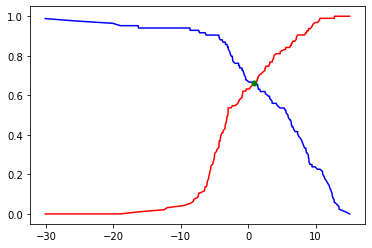

EER: 0.6631578947368421


In [82]:
predicted = use_svm(df_train[train_x_columns],df_test[train_x_columns])
plot_far_eer(df_test[train_y_columns], predicted)

In [ ]:
predicted = use_svm(df_train[train_x_columns],df_test[train_x_columns])

df_results =  df_test[[train_y_columns,'id']]
df_results['prediction'] = predicted


nieco=df_results.groupby([train_y_columns,'id']).mean()
nieco=nieco.reset_index().drop('id', axis=1)

# test_y, predicted_y = unify_y_column_format(nieco[train_y_columns], nieco['prediction'], selected_owners,treshold_for_knn)
# show_results(test_y,predicted_y)

plot_far_eer(nieco[train_y_columns],nieco['prediction'])

In [ ]:
train_x_columns=selected_features_dict[125]
len(train_x_columns)

In [38]:
df_raw_train, df_raw_val, df_raw_test = split_to_train_val_test_raw(all_features)

if not delete_nan_features:
    df_raw_train, df_raw_val, df_raw_test =  use_imputation([df_raw_train, df_raw_val, df_raw_test], train_x_columns)
    
df_raw_train.to_csv(path_to_featutes + "imputed/" + "train.csv", encoding='utf-8', index=False)
df_raw_val.to_csv(path_to_featutes + "imputed/" + "val.csv", encoding='utf-8', index=False)
df_raw_test.to_csv(path_to_featutes + "imputed/" + "test.csv", encoding='utf-8', index=False)

[IterativeImputer] Completing matrix with shape (10121, 352)
[IterativeImputer] Ending imputation round 1/30, elapsed time 413.94
[IterativeImputer] Change: 31.316245237235506, scaled tolerance: 0.05980885567887388 
[IterativeImputer] Ending imputation round 2/30, elapsed time 792.22
[IterativeImputer] Change: 8.499818490692507, scaled tolerance: 0.05980885567887388 
[IterativeImputer] Ending imputation round 3/30, elapsed time 1145.18
[IterativeImputer] Change: 4.881654645614115, scaled tolerance: 0.05980885567887388 
[IterativeImputer] Ending imputation round 4/30, elapsed time 1494.18
[IterativeImputer] Change: 3.5720867874484705, scaled tolerance: 0.05980885567887388 
[IterativeImputer] Ending imputation round 5/30, elapsed time 1848.26
[IterativeImputer] Change: 2.8449358658875914, scaled tolerance: 0.05980885567887388 
[IterativeImputer] Ending imputation round 6/30, elapsed time 2198.92
[IterativeImputer] Change: 2.36155635508788, scaled tolerance: 0.05980885567887388 
[Iterativ

[IterativeImputer] Ending imputation round 20/30, elapsed time 44.77
[IterativeImputer] Ending imputation round 21/30, elapsed time 46.98
[IterativeImputer] Ending imputation round 22/30, elapsed time 49.20
[IterativeImputer] Ending imputation round 23/30, elapsed time 51.42
[IterativeImputer] Ending imputation round 24/30, elapsed time 53.64
[IterativeImputer] Ending imputation round 25/30, elapsed time 55.86
[IterativeImputer] Ending imputation round 26/30, elapsed time 58.08
[IterativeImputer] Ending imputation round 27/30, elapsed time 60.30
[IterativeImputer] Ending imputation round 28/30, elapsed time 62.52
[IterativeImputer] Ending imputation round 29/30, elapsed time 64.75
[IterativeImputer] Ending imputation round 30/30, elapsed time 66.95
[IterativeImputer] Completing matrix with shape (3474, 352)
[IterativeImputer] Ending imputation round 1/30, elapsed time 1.65
[IterativeImputer] Ending imputation round 2/30, elapsed time 3.34
[IterativeImputer] Ending imputation round 3/30

In [ ]:
selected_features_dict = {}
selected_features_dict[0]=train_x_columns

class RandomForestClassifierWithCoef(RandomForestClassifier):
    def fit(self, *args, **kwargs):
        super(RandomForestClassifierWithCoef, self).fit(*args, **kwargs)
        self.coef_ = self.feature_importances_
        
models = [LogisticRegression(solver='lbfgs'), RandomForestClassifierWithCoef(n_estimators=500, min_samples_leaf=5, n_jobs=-1)]


for model in models:
    print(model)
    rfe = RFE(model, 1)
    fit = rfe.fit(df_raw_train[train_x_columns], df_raw_train[train_y_columns])

    # print("Num Features: %d" % fit.n_features_)
    # print("Selected Features: %s" % fit.support_)
    # print("Feature Ranking: %s" % fit.ranking_)
    for number in [x * 10 for x in list(range(1,12))]:
        indexes_to_delete=[]
        for i in range(len(fit.ranking_)):
            if(fit.ranking_[i] > number):
                indexes_to_delete.append(i)
        selected_features = [i for j, i in enumerate(train_x_columns) if j not in indexes_to_delete]
        selected_features_dict[str(number) + "_" + str(model)]=selected_features
        
    rfe = RFECV(estimator=model, verbose=2)
    fit = rfe.fit(df_raw_train[train_x_columns], df_raw_train[train_y_columns])


    indexes_to_delete=[]
    for i in range(len(fit.ranking_)):
        if(fit.ranking_[i] != 1):
            indexes_to_delete.append(i)
    selected_features = [i for j, i in enumerate(train_x_columns) if j not in indexes_to_delete]
    selected_features_dict["A_" + str(model)]=selected_features

for k in selected_features_dict.keys():
    new_key = ' '.join(str(k).replace("\\n", " ").split())
    selected_features_dict[new_key] = selected_features_dict.pop(k)
print(selected_features_dict)

In [177]:
df_raw_train = pd.read_csv(path_to_featutes  + "imputed/" + "train.csv", sep=',')
df_raw_val = pd.read_csv(path_to_featutes  + "imputed/" + "val.csv", sep=',')
df_raw_test = pd.read_csv(path_to_featutes  + "imputed/" + "test.csv", sep=',')

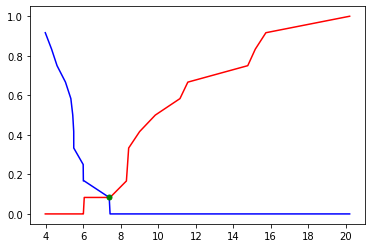

EER: 0.08333333333333333
4.792191028594971


In [114]:
predict_based_on_whole_pattern = True
start = time.time()
selected_owners = 'Stevo'
df_train, df_val, df_test = adapt_dfs_to_users(df_raw_train, df_raw_val, df_raw_test, selected_owners,0)

knn = get_knn()
knn.fit(df_train[train_x_columns])

predicted_test=[np.mean(i) for i in knn.kneighbors(df_test[train_x_columns])[0]]

ground_truth_test, predicted_test = adapt_columns_for_evaluation(df_test[[train_y_columns,'id']], predicted_test, predict_based_on_whole_pattern) 

plot_far_eer(ground_truth_test, predicted_test)
end = time.time()
print(end-start)

In [136]:
test_eer_array=[]
val_eer_array=[]
train_eer_array=[]

predict_based_on_whole_pattern = True
start = time.time()
users_to_cv=df_raw_train[user_name_column].unique()
for selected_owners in users_to_cv:
    df_train, df_val, df_test = adapt_dfs_to_users(df_raw_train, df_raw_val, df_raw_test, selected_owners,2)
    
    knn = get_knn()
    knn.fit(df_train[train_x_columns])
    
    predicted_train=[np.mean(i) for i in knn.kneighbors(df_train[train_x_columns])[0]]
    predicted_val=[np.mean(i) for i in knn.kneighbors(df_val[train_x_columns])[0]]
    predicted_test=[np.mean(i) for i in knn.kneighbors(df_test[train_x_columns])[0]]
    
    ground_truth_train, predicted_train = adapt_columns_for_evaluation(df_train[[train_y_columns,'id']], predicted_train, predict_based_on_whole_pattern)
    train_eer_array.append(get_eer(ground_truth_train, predicted_train))
    
    ground_truth_val, predicted_val = adapt_columns_for_evaluation(df_val[[train_y_columns,'id']], predicted_val, predict_based_on_whole_pattern)
    val_eer_array.append(get_eer(ground_truth_val, predicted_val))
    
    ground_truth_test, predicted_test = adapt_columns_for_evaluation(df_test[[train_y_columns,'id']], predicted_test, predict_based_on_whole_pattern)
    test_eer_array.append(get_eer(ground_truth_test, predicted_test))
    
train_eer = mean(train_eer_array)    
val_eer = mean(val_eer_array)
test_eer = mean(test_eer_array)
end = time.time()
print(end-start)

74.18269157409668


In [137]:
val_eer

0.264520202020202

In [126]:
test_eer

0.33501776001776

In [139]:
test_eer_array

[0.5,
 0.2857142857142857,
 0.4,
 0.36363636363636365,
 0.5,
 0.1111111111111111,
 0.16666666666666666,
 0.4,
 0.3333333333333333,
 0.6666666666666666,
 0.3333333333333333,
 0.2,
 0.4,
 0.3333333333333333,
 0.0,
 0.0,
 0.3333333333333333,
 0.6,
 0.25,
 0.16666666666666666,
 0.2,
 0.4,
 0.16666666666666666,
 0.6,
 0.5,
 0.5]

In [157]:
all_features_subset = selected_features_dict.keys()
all_knn_l = list(range(1,4))
all_knn_n_neighbors= list(range(1,6))
all_predict_based_on_whole_pattern = [True, False]
kind_of_patterns = [0,1,2]
iterables = [all_features_subset, all_knn_l, all_knn_n_neighbors, all_predict_based_on_whole_pattern, kind_of_patterns]

In [95]:
rows = []
for features_subset, knn_l, knn_n_neighbors, predict_based_on_whole_pattern,kind_of_patten in itertools.product(*iterables):
    
    test_eer_array=[]
    val_eer_array=[]


    for selected_owners in users_to_cv:
        df_train, df_val, df_test = adapt_dfs_to_users(df_raw_train, df_raw_val, df_raw_test, selected_owners,kind_of_patten)

        knn = get_knn(knn_n_neighbors, knn_l)
        knn.fit(df_train[selected_features_dict[features_subset]])

        predicted_val=[np.mean(i) for i in knn.kneighbors(df_val[selected_features_dict[features_subset]])[0]]
        predicted_test=[np.mean(i) for i in knn.kneighbors(df_test[selected_features_dict[features_subset]])[0]]


        ground_truth_val, predicted_val = adapt_columns_for_evaluation(df_val[[train_y_columns,'id']], predicted_val, predict_based_on_whole_pattern)
        val_eer_array.append(get_eer(ground_truth_val, predicted_val))

        ground_truth_test, predicted_test = adapt_columns_for_evaluation(df_test[[train_y_columns,'id']], predicted_test, predict_based_on_whole_pattern)
        test_eer_array.append(get_eer(ground_truth_test, predicted_test))


    val_eer = mean(val_eer_array)
    test_eer = mean(test_eer_array)
    
    rows.append([features_subset, knn_l, knn_n_neighbors, predict_based_on_whole_pattern, kind_of_patten , val_eer, test_eer])
    print(len(rows))

df_tuning = pd.DataFrame(rows, columns=["features_subset", "knn_l", "knn_n_neighbors", "predict_based_on_whole_pattern", "val_eer", "test_eer"])
df_tuning.to_csv("../results/tuning_result.csv", encoding='utf-8', index=False)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


ValueError: at least one array or dtype is required

In [134]:
pole= [0.0, 0.0, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
all(x == 0.0 for x in pole)

False

In [158]:
#df_raw_train, df_raw_val, df_raw_test
id1=df_raw_train['id'].unique()
id2=df_raw_val['id'].unique()
id3=df_raw_test['id'].unique()
for a in id1:
    if(a in id2 or a in id3):
        print("zle")
        
for a in id2:
    if(a in id3):
        print("zle")

In [169]:
df_raw_train.value_counts(subset=[user_name_column, 'scenario']) 

username      scenario             
hawkie94      scenario_show_complex    363
              scenario_show_simple     329
banas         scenario_show_complex    317
martin        scenario_show_complex    305
kitti         scenario_show_complex    261
mimo          scenario_show_complex    260
baxos         scenario_show_complex    252
fero          scenario_show_complex    252
Stevo         scenario_show_complex    252
lukasb        scenario_show_complex    251
Miki          scenario_show_complex    250
Matúš Cuper   scenario_show_complex    243
Martina       scenario_show_complex    243
Jakub.m       scenario_show_complex    242
IM            scenario_show_complex    240
vargaf        scenario_show_complex    234
blinky        scenario_show_complex    234
tany          scenario_show_complex    225
michal        scenario_show_complex    224
Martin        scenario_show_complex    216
Ivi           scenario_show_complex    216
tom990        scenario_show_complex    215
Filip         scen

In [172]:
df_raw_val.value_counts(subset=[user_name_column, 'scenario']) 

username         scenario             
mino             scenario_show_complex    171
Jozef Schneider  scenario_show_complex    162
luci             scenario_show_complex    144
PeterB           scenario_show_complex    144
denisgr          scenario_show_complex    142
                                         ... 
TomasM           scenario_show_simple      25
Ivi              scenario_show_simple      25
tom990           scenario_show_simple      25
Matej Adamov     scenario_show_simple      23
AdamT            scenario_show_simple      23
Length: 63, dtype: int64

In [173]:
df_raw_test.value_counts(subset=[user_name_column, 'scenario']) 

username         scenario             
mino             scenario_show_complex    171
luci             scenario_show_complex    151
Jozef Schneider  scenario_show_complex    145
denisgr          scenario_show_complex    140
PeterB           scenario_show_complex    133
                                         ... 
AdamT            scenario_show_simple      28
Martin           scenario_show_simple      27
IM               scenario_show_simple      27
baxos            scenario_show_simple      26
Matej Adamov     scenario_show_simple      25
Length: 63, dtype: int64

In [175]:
df_raw_test['id']

0       576Device2
1       731Device6
2       407Device2
3       547Device2
4       110Device3
           ...    
3469    747Device9
3470    407Device2
3471    260Device9
3472    933Device7
3473    381Device6
Name: id, Length: 3474, dtype: object